<a href="https://colab.research.google.com/github/JamKia/Graph-tool-1/blob/main/Graph_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import graph_tool.all as gt
import datetime
import missingno as msno
from stochastic.noise import FractionalGaussianNoise
from tqdm import tqdm_notebook

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
print(current_dir)
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

/home/jamshid/Dropbox/Mapping Coupled Timeseries onto network/6- peer reviewed-DJIA-S&P500-SSEC


In [ ]:
Hurst_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def fGn_DataSource(Hurst, max_ensemble_no = 32, length = 2000):

    def fGn(Hurst, length = length, t=1):
        from stochastic.noise import FractionalGaussianNoise
        fgn = FractionalGaussianNoise(Hurst, t)
        array_series = fgn.sample(n=length+1 , algorithm='hosking')
        return array_series
    
    
    df_fGn = pd.DataFrame()
    for ensemble_no in range(0,max_ensemble_no):
        df_fGn['no_'+str(ensemble_no)] = pd.Series(fGn(Hurst= Hurst, length= length, t=1))
        df_fGn['no_'+str(ensemble_no)+'_lag'] = df_fGn['no_'+str(ensemble_no)].shift(1)
            
    df_fGn.dropna(axis=0, inplace=True)
    df_fGn.reset_index(inplace=True, drop=True)
            
    return df_fGn

############################################################################
def AdjMatrix_list(df, numBins = 60, max_ensemble_no = 32):

    def Cross_jointProbability(df,column_name1, column_name2, numBins = numBins):
        import numpy as np
        jointProbs, edges = np.histogramdd([df[column_name1],
                                            df[column_name2]],
                                            bins = numBins)
        jointProbs /= jointProbs.sum()
        return jointProbs
    
#     print(len(df.columns))
    AdjMatrix_list = []
    
    for ensemble_no in range(0, max_ensemble_no):
        print('column_name1 = no_'+ str(ensemble_no))
        print('column_name1 = no_'+ str(ensemble_no)+'_lag')

        AdjMatrix_list += [Cross_jointProbability(df,
                               column_name1 = 'no_'+ str(ensemble_no),
                               column_name2 = 'no_'+ str(ensemble_no)+'_lag')
                              ]
        
    return AdjMatrix_list

############################################################################
def Deformation_list(AdjMatrix_list, max_offest, max_ensemble_no ):
    
    def Deformation(AdjMat, max_offest):
        # Main Dia.
        diag_main_std = []
        for i in range( -max_offest, max_offest+1 ):
            diag_main_offset = np.diagonal(AdjMat, offset=i)
            diag_main_std += [diag_main_offset.std()]
        max_std_Main = max(diag_main_std)

        # Non-main Dia.
        AdjMat_rot90 = np.rot90(AdjMat, k=1).copy()
        diag_NONmain_std =[]
        for i in range( -max_offest, max_offest+1 ):
            diag_NONmain_offset = np.diagonal(AdjMat_rot90, offset=i)
            diag_NONmain_std +=[diag_NONmain_offset.std()]
        max_std_NONMain = max(diag_NONmain_std)

        R = (max_std_Main - max_std_NONMain) / max(max_std_Main, max_std_NONMain)
        return R

    Deformation_list = []
    for ensemble_no in range(0, max_ensemble_no):
        Deformation_list += [
                              Deformation(AdjMatrix_list[ensemble_no], max_offest)
                              ]

    return Deformation_list
    

In [ ]:
def to_graphtool_sfdp_layout(df_AdjacencyWeightedMatrix):

#     central_vertex_index = max_lender_index(df_adj_matrix)    
    
    #--------------------------

    import graph_tool as gt
    g = gt.Graph(directed=True)
    edge_weights = g.new_edge_property('double')

    g.edge_properties['weight'] = edge_weights
    num_vertices = len(df_AdjacencyWeightedMatrix.values)

    for i in range(0,num_vertices):
        for j in range(i,num_vertices):
            if df_AdjacencyWeightedMatrix.values[i,j]!=0:
                e = g.add_edge(i,j)
                edge_weights[e] = df_AdjacencyWeightedMatrix.values[i,j]


    for i in range(1,num_vertices):
        for j in range(0,i):
            if df_AdjacencyWeightedMatrix.values[i,j]!=0:
                e = g.add_edge(i,j)
                edge_weights[e] = df_AdjacencyWeightedMatrix.values[i,j]


    #print("g.vertex_index:\n", list(g.vertex_index))
    #--------------------------

    deg_out = g.degree_property_map("out")
    deg_total = g.degree_property_map("total")
    
#     pos = gt.draw.radial_tree_layout(g, root = g.vertex(central_vertex_index), rel_order = deg)
#     pos = gt.draw.fruchterman_reingold_layout(g, circular=True)
#     pos = gt.draw.random_layout(g)
    pos = gt.draw.sfdp_layout(g)
    pos = gt.draw.arf_layout(g)

    
#     import matplotlib
#     gt.draw.graph_draw(g, pos=pos, #vprops=None, eprops=None,
#                        edge_pen_width=gt.draw.prop_to_size(g.ep.weight, 3, 8, power=10, log=True),
#                        edge_color=gt.draw.prop_to_size(g.ep.weight,1, 10, power=1, log=True),
#                        ecmap=(matplotlib.cm.viridis_r, .6), #BuPu, viridis_r, Wistia, inferno_r
#                        eorder=g.ep.weight,
#                        #vertex_color=[1,1,1,0],
#                        vertex_fill_color= deg_total,
#                        #vcolor=deg,
#                        #vorder=deg,
#                        vertex_text= g.vertex_index,
#                        vertex_size= deg_out,
#                        vertex_font_size=10,
#                        vcmap=matplotlib.cm.viridis_r, #gist_heat_r, nipy_spectral ,BuPu ,YlGn
#                        fit_view= True, fmt="png",
#                        output_size=(600, 600),
#                        #output=path_to_save+"H="+str(Hurst)+".png"
#                       )
    
    # Deformation
    def Deformation(AdjMat, max_offest):
        # Main Dia.
        diag_main_std = []
        for i in range( -max_offest, max_offest+1 ):
            diag_main_offset = np.diagonal(AdjMat, offset=i)
            diag_main_std += [diag_main_offset.std()]
        max_std_Main = max(diag_main_std)

        # Non-main Dia.
        AdjMat_rot90 = np.rot90(AdjMat, k=1).copy()
        diag_NONmain_std =[]
        for i in range( -max_offest, max_offest+1 ):
            diag_NONmain_offset = np.diagonal(AdjMat_rot90, offset=i)
            diag_NONmain_std +=[diag_NONmain_offset.std()]
        max_std_NONMain = max(diag_NONmain_std)

        R = (max_std_Main - max_std_NONMain) / max(max_std_Main, max_std_NONMain)
        return R
    
    Adj_matrix = gt.spectral.adjacency(g, weight = g.ep.weight).todense()
    deformation_ratio = Deformation(df_AdjacencyWeightedMatrix.values, max_offest=10)
    #print('deformation_ratio:',deformation_ratio)
    
    # stats
    deg_total_avg, deg_total_std = gt.stats.vertex_average(g, 'total')
    deg_HistCount, deg_HistEdges = gt.stats.vertex_hist(g, 'total')
    shortest_dist_HistCount, shortest_dist_HistEdges = gt.stats.distance_histogram(g)
    count_vertices = g.num_vertices()
    count_edges = g.num_edges()
    
    array_out_deg = g.get_out_degrees(g.get_vertices())
    mean_out_deg = array_out_deg.mean()
    
    array_in_deg = g.get_in_degrees(g.get_vertices())
    mean_in_deg = array_in_deg.mean()
    
    array_total_deg = array_out_deg + array_in_deg
    mean_total_deg = array_total_deg.mean()

    mean_of_squared_out_deg = np.power(array_out_deg,2).mean()
    mean_of_squared_in_deg = np.power(array_in_deg,2).mean()
    mean_of_squared_total_deg = np.power(array_total_deg,2).mean()

    # clustering
    local_clust_mean_directed = gt.clustering.local_clustering(g,
                                           #weight = g.ep.weight, # ??????
                                           #prop = deg_total,
                                           undirected = False
                                          ).a.mean()
    local_clust_mean_undirected = gt.clustering.local_clustering(g,
                                           #weight = g.ep.weight, # ??????
                                           #prop = deg_total,
                                           undirected = True
                                          ).a.mean()
    global_clustCoef, global_clustCoef_std = gt.clustering.global_clustering(g)

        # topology
    undirected_distance_list =[]
    directed_distance_list =[]
    undirected_weighted_distance_list =[]
    directed_weighted_distance_list =[]
    
    inf_length_PAIR_vertices_undirected =[]    
    inf_length_PAIR_vertices_directed =[]
    inf_length_vertices_list = []
    
    for v in g.vertices():
        for w in g.vertices():
            ###### UNweighted ##################
            UNDIRECTED_shortest_distance = gt.topology.shortest_distance(g,
                                                                          source = v,
                                                                          target = w,
                                                                          directed = False)
            DIRECTED_shortest_distance   = gt.topology.shortest_distance(g,
                                                                          source = v,
                                                                          target = w,
                                                                          directed = True)
            if UNDIRECTED_shortest_distance < 2147483640:
                                        undirected_distance_list += [UNDIRECTED_shortest_distance]
            else: 
                inf_length_PAIR_vertices_undirected += [(g.vertex_index[v],g.vertex_index[w])]

                
            if DIRECTED_shortest_distance   < 2147483640:
                                        directed_distance_list   += [DIRECTED_shortest_distance]
            else: 
                inf_length_PAIR_vertices_directed   += [(g.vertex_index[v],g.vertex_index[w])]
                inf_length_vertices_list += [g.vertex_index[v]]
                inf_length_vertices_list += [g.vertex_index[w]]

                
            ###### weighted ##################
            weighted_UNDIRECTED_shortest_distance = gt.topology.shortest_distance(g,
                                                                              source = v,
                                                                              target = w,
                                                                              directed = False,
                                                                              weights = g.ep.weight)
            weighted_DIRECTED_shortest_distance   = gt.topology.shortest_distance(g,
                                                                              source = v,
                                                                              target = w,
                                                                              directed = True,
                                                                              weights = g.ep.weight)
            if weighted_UNDIRECTED_shortest_distance < 2147483640:
                                        undirected_weighted_distance_list += [weighted_UNDIRECTED_shortest_distance]
                

            if weighted_DIRECTED_shortest_distance   < 2147483640:
                                        directed_weighted_distance_list   += [weighted_DIRECTED_shortest_distance]
            

    #print("undirected_distance_list:\n",undirected_distance_list)   
    print("inf_length_PAIR_vertices_undirected:\n", inf_length_PAIR_vertices_undirected)
    mean_undirected_length = np.mean(undirected_distance_list)
    
    #print("directed_distance_list:\n",directed_distance_list)   
    print("inf_length_PAIR_vertices_directed:\n", inf_length_PAIR_vertices_directed)
    mean_directed_length = np.mean(directed_distance_list)
    print("inf_length_vertices_list:\n", inf_length_vertices_list)
    
    mean_undirected_weighted_length = np.mean(undirected_weighted_distance_list)
    mean_directed_weighted_length = np.mean(directed_weighted_distance_list)
    
    
    # correlation
    assortativity_coef, assortativity_coef_var = gt.correlations.assortativity(g,
                                                                               deg='total', # in, out, total
                                                                               #eweight = None #g.ep.weight    #?????????
                                                                              )
    scalar_assortativity_coef, scalar_assortativity_coef_var = gt.correlations.scalar_assortativity(g,
                                                                               deg='total', # in, out, total
                                                                               #eweight = None #g.ep.weight    #?????????
                                                                                                    )

    # modularity
    deg_out = g.degree_property_map("out")
    deg_total = g.degree_property_map("total")
    
    #vertex_properties_degree = g.new_vertex_property('double')
    #g.vertex_properties['degree'] = vertex_properties_degree

    modularity_deg_out = gt.inference.modularity(g, deg_out, weight = g.ep.weight)
    #print("modularity_deg_out: ",modularity_deg_out)
    modularity_deg_total = gt.inference.modularity(g, deg_total, weight = g.ep.weight)
    #print("modularity_deg_total: ",modularity_deg_total)

    columns = [
               'mean_of_squared_out_deg',
               'mean_of_squared_in_deg',
               'mean_of_squared_total_deg',
               'mean_out_deg',
               'mean_in_deg',
               'mean_total_deg',
               'deg_total_std',
               'global_clustCoef_std',
               'local_clust_mean_undirected',
               'local_clust_mean_directed',
               'global_clustCoef',
               'scalar_assortativity_coef_var',
               'mean_directed_length',
               'mean_undirected_length',
               'assortativity_coef_var',
               #'mean_undirected_weighted_length',
               #'mean_directed_weighted_length', 
               'assortativity_coef',
               'scalar_assortativity_coef',
               'deformation_ratio',
               'modularity_deg_total',
                'modularity_deg_out',
              ]
    
    frame = [(
              #Hurst,
        mean_of_squared_out_deg,
        mean_of_squared_in_deg,
        mean_of_squared_total_deg,
        mean_out_deg,
        mean_in_deg,
        mean_total_deg,
        deg_total_std,
        global_clustCoef_std,
        local_clust_mean_undirected,
        local_clust_mean_directed,
        global_clustCoef,
        scalar_assortativity_coef_var,
        mean_directed_length,
        mean_undirected_length,
        assortativity_coef_var,
        # mean_undirected_weighted_length,
        #mean_directed_weighted_length,
        assortativity_coef,
        scalar_assortativity_coef,
        deformation_ratio,
        modularity_deg_total,
        modularity_deg_out,
            )]
    
    df = pd.DataFrame(data = frame, columns= columns)

    return df #g, 

def Network_measurement(AdjMatrix_list, max_ensemble_no):
    Network_measurement_df_list = []
    for ensemble_no in range(0, max_ensemble_no):
        df_AdjMat = pd.DataFrame(AdjMatrix_list[ensemble_no])
        df_Network_measurement = to_graphtool_sfdp_layout(df_AdjMat)
        df_Network_measurement.rename( index={0: ensemble_no}, inplace =True)

        Network_measurement_df_list += [
                              df_Network_measurement.T
                              ]
    Network_measurement_df = pd.concat(Network_measurement_df_list, axis=1, ignore_index = False)

    return Network_measurement_df # ,Network_measurement_df_list

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.1

# df_H_1_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_1_ensemble_series.to_pickle(path+'df_H_1_ensemble_series.pickle')
df_H_1_ensemble_series = pd.read_pickle(path+'df_H_1_ensemble_series.pickle')

list_H_1_ensemble_AdjMat = AdjMatrix_list(df_H_1_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_1_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_1_ensemble_AdjMat, f)
# list_H_1_ensemble_AdjMat.to_pickle(path+'list_H_1_ensemble_AdjMat.pickle')
with open(path+'list_H_1_ensemble_AdjMat.pkl', 'rb') as f: list_H_1_ensemble_AdjMat = pickle.load(f)
# list_H_1_ensemble_AdjMat = pd.read_pickle(path+'list_H_1_ensemble_AdjMat.pickle')

df_H_1_ensemble_Network = Network_measurement(list_H_1_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_1_ensemble_Network.to_pickle(path+'df_H_1_ensemble_Network.pickle')
df_H_1_ensemble_Network = pd.read_pickle(path+'df_H_1_ensemble_Network.pickle')

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 5), (0, 9), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 5), (2, 9), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41),

inf_length_PAIR_vertices_undirected:
 [(0, 4), (0, 53), (0, 55), (0, 57), (0, 58), (1, 4), (1, 53), (1, 55), (1, 57), (1, 58), (2, 4), (2, 53), (2, 55), (2, 57), (2, 58), (3, 4), (3, 53), (3, 55), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 45), (4, 46), (4, 47), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (5, 4), (5, 53), (5, 55), (5, 57), (5, 58), (6, 4), (6, 53), (6, 55), (6, 57), (6, 58), (7, 4), (7, 53), (7, 55), (7, 57), (7, 58), (8, 4), (8, 53), (8, 55), (8, 57), (8, 58), (9, 4), (9, 53), (9, 55), (9, 57), (9, 58), (10, 4), (10, 53), (10, 55), (10, 57), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 55), (0, 56), (0, 58), (1, 2), (1, 55), (1, 56), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 55), (3, 56), (3, 58), (4, 2), (4, 55), (4, 56), (4, 58), (5, 2), (5, 55), (5, 56), (5, 58), (6, 2), (6, 55), (6, 56), (6, 58), (7, 2), (7, 55), (7, 56), (7, 58), (8, 2), (8, 55), (8, 56), (8, 58), (9, 2), (9, 55), (9, 56), (9, 58), (10, 2), (10, 55), (10, 56), (10, 58), (11, 2), (11, 55), (11, 56), (11, 58), (12, 2), (12, 55), (12, 56), (12, 58), (13, 2)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 52), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), 

inf_length_PAIR_vertices_undirected:
 [(0, 49), (0, 50), (0, 51), (0, 52), (0, 56), (0, 57), (0, 58), (1, 49), (1, 50), (1, 51), (1, 52), (1, 56), (1, 57), (1, 58), (2, 49), (2, 50), (2, 51), (2, 52), (2, 56), (2, 57), (2, 58), (3, 49), (3, 50), (3, 51), (3, 52), (3, 56), (3, 57), (3, 58), (4, 49), (4, 50), (4, 51), (4, 52), (4, 56), (4, 57), (4, 58), (5, 49), (5, 50), (5, 51), (5, 52), (5, 56), (5, 57), (5, 58), (6, 49), (6, 50), (6, 51), (6, 52), (6, 56), (6, 57), (6, 58), (7, 49), (7, 50), (7, 51), (7, 52), (7, 56), (7, 57), (7, 58), (8, 49), (8, 50), (8, 51), (8, 52), (8, 56), (8, 57), (8, 58), (9, 49), (9, 50), (9, 51), (9, 52), (9, 56), (9, 57), (9, 58), (10, 49), (10, 50), (10, 51), (10, 52), (10, 56), (10, 57), (10, 58), (11, 49), (11, 50), (11, 51), (11, 52), (11, 56), (11, 57), (11, 58), (12, 49), (12, 50), (12, 51), (12, 52), (12, 56), (12, 57), (12, 58), (13, 49), (13, 50), (13, 51), (13, 52), (13, 56), (13, 57), (13, 58), (14, 49), (14, 50), (14, 51), (14, 52), (14, 56), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (1, 2), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, 2), (36, 2), (37, 2), (38, 2), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 54), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 54), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 57), (1, 2), (1, 4), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 55), (0, 56), (0, 57), (0, 58), (1, 55), (1, 56), (1, 57), (1, 58), (2, 55), (2, 56), (2, 57), (2, 58), (3, 55), (3, 56), (3, 57), (3, 58), (4, 55), (4, 56), (4, 57), (4, 58), (5, 55), (5, 56), (5, 57), (5, 58), (6, 55), (6, 56), (6, 57), (6, 58), (7, 55), (7, 56), (7, 57), (7, 58), (8, 55), (8, 56), (8, 57), (8, 58), (9, 55), (9, 56), (9, 57), (9, 58), (10, 55), (10, 56), (10, 57), (10, 58), (11, 55), (11, 56), (11, 57), (11, 58), (12, 55), (12, 56), (12, 57), (12, 58), (13, 55), (13, 56), (13, 57), (13, 58), (14, 55), (14, 56), (14, 57), (14, 58), (15, 55), (15, 56), (15, 57), (15, 58), (16, 55), (16, 56), (16, 57), (16, 58), (17, 55), (17, 56), (17, 57), (17, 58), (18, 55), (18, 56), (18, 57), (18, 58), (19, 55), (19, 56), (19, 57), (19, 58), (20, 55), (20, 56), (20, 57), (20, 58), (21, 55), (21, 56), (21, 57), (21, 58), (22, 55), (22, 56), (22, 57), (22, 58), (23, 55), (23, 56), (23, 57), (23, 58), (24, 55), (24, 56), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 58), (1, 2), (1, 4), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 4), (0, 55), (0, 56), (1, 4), (1, 55), (1, 56), (2, 4), (2, 55), (2, 56), (3, 4), (3, 55), (3, 56), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 45), (4, 46), (4, 47), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (5, 4), (5, 55), (5, 56), (6, 4), (6, 55), (6, 56), (7, 4), (7, 55), (7, 56), (8, 4), (8, 55), (8, 56), (9, 4), (9, 55), (9, 56), (10, 4), (10, 55), (10, 56), (11, 4), (11, 55), (11, 56), (12, 4), (12, 55), (12, 56), (13, 4), (13, 55), (13, 56), (14, 4), (14, 55), (14, 56), (15, 4), (15, 55), (15, 56), (16, 4), (16, 55), (16, 56), (1

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 6), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 56), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 53), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 3

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 6), (0, 56), (0, 57), (1, 2), (1, 4), (1, 6), (1, 56), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 6), (3, 56), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 5), (0, 55), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 5), (2, 55), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 52), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 3

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 57), (1, 2), (1, 3), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 54), (0, 56), (0, 58), (1, 2), (1, 54), (1, 56), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 54), (3, 56), (3, 58), (4, 2), (4, 54), (4, 56), (4, 58), (5, 2), (5, 54), (5, 56), (5, 58), (6, 2), (6, 54), (6, 56), (6, 58), (7, 2), (7, 54), (7, 56), (7, 58), (8, 2), (8, 54), (8, 56), (8, 58), (9, 2), (9, 54), (9, 56), (9, 58), (10, 2), (10, 54), (10, 56), (10, 58), (11, 2), (11, 54), (11, 56), (11, 58), (12, 2), (12, 54), (12, 56), (12, 58), (13, 2)

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 5), (0, 55), (0, 56), (0, 57), (1, 2), (1, 4), (1, 5), (1, 55), (1, 56), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 5), (3, 55), (3, 56), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 56), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (

inf_length_PAIR_vertices_undirected:
 [(0, 58), (1, 58), (2, 58), (3, 58), (4, 58), (5, 58), (6, 58), (7, 58), (8, 58), (9, 58), (10, 58), (11, 58), (12, 58), (13, 58), (14, 58), (15, 58), (16, 58), (17, 58), (18, 58), (19, 58), (20, 58), (21, 58), (22, 58), (23, 58), (24, 58), (25, 58), (26, 58), (27, 58), (28, 58), (29, 58), (30, 58), (31, 58), (32, 58), (33, 58), (34, 58), (35, 58), (36, 58), (37, 58), (38, 58), (39, 58), (40, 58), (41, 58), (42, 58), (43, 58), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (52, 58), (53, 58), (54, 58), (55, 58), (56, 58), (57, 58), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (58, 8), (58, 9), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (58, 19), (58, 20), (58, 21), (58, 22), (58, 23), (58, 24), (58, 25), (58, 26), (58, 27), (58, 28), (58, 29), (58, 30), (58, 31), (58, 32), (58, 33), (58, 34), (58, 35), (58, 36), (58, 37), (58, 38), (58, 39), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 54), (0, 58), (1, 2), (1, 54), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 54), (3, 58), (4, 2), (4, 54), (4, 58), (5, 2), (5, 54), (5, 58), (6, 2), (6, 54), (6, 58), (7, 2), (7, 54), (7, 58), (8, 2), (8, 54), (8, 58), (9, 2), (9, 54), (9, 58), (10, 2), (10, 54), (10, 58), (11, 2), (11, 54), (11, 58), (12, 2), (12, 54), (12, 58), (13, 2), (13, 54), (13, 58), (14, 2), (14, 54), (14, 58), (15, 2), (15, 54), (15, 58), (16, 2), (16, 54), (16, 58), (1

inf_length_PAIR_vertices_undirected:
 [(0, 58), (1, 58), (2, 58), (3, 58), (4, 58), (5, 58), (6, 58), (7, 58), (8, 58), (9, 58), (10, 58), (11, 58), (12, 58), (13, 58), (14, 58), (15, 58), (16, 58), (17, 58), (18, 58), (19, 58), (20, 58), (21, 58), (22, 58), (23, 58), (24, 58), (25, 58), (26, 58), (27, 58), (28, 58), (29, 58), (30, 58), (31, 58), (32, 58), (33, 58), (34, 58), (35, 58), (36, 58), (37, 58), (38, 58), (39, 58), (40, 58), (41, 58), (42, 58), (43, 58), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (52, 58), (53, 58), (54, 58), (55, 58), (56, 58), (57, 58), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (58, 8), (58, 9), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (58, 19), (58, 20), (58, 21), (58, 22), (58, 23), (58, 24), (58, 25), (58, 26), (58, 27), (58, 28), (58, 29), (58, 30), (58, 31), (58, 32), (58, 33), (58, 34), (58, 35), (58, 36), (58, 37), (58, 38), (58, 39), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 6), (0, 58), (1, 2), (1, 6), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 6), (3, 58), (4, 2), (4, 6), (4, 58), (5, 2), (5, 6), (5, 58), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 28), (6, 29), (6, 30), (6, 31), (6, 32), (6, 33), (6, 34), (6, 35), (6, 36),

In [ ]:
df_H_1_ensemble_Network

0                    1   \
mean_of_squared_out_deg                    302.367              373.383   
mean_of_squared_in_deg                       306.4              370.183   
mean_of_squared_total_deg                  1213.37              1483.03   
mean_out_deg                               13.3667              15.3833   
mean_in_deg                                13.3667              15.3833   
mean_total_deg                             26.7333              30.7667   
deg_total_std                              2.88298              2.99011   
global_clustCoef_std                     0.0123113            0.0165848   
local_clust_mean_undirected     0.5585860446723091   0.6941096890578481   
local_clust_mean_directed      0.42195022583744674  0.45671254027644875   
global_clustCoef                          0.690385              0.71183   
scalar_assortativity_coef_var            0.0402728            0.0349981   
mean_directed_length                        1.9635              1.83069   
mean_undirected_length                     1.70649              1.63036   
assortativity_coef_var                  0.00914236           0.00656489   
assortativity_coef                     -0.00649638          -0.00775107   
scalar_assortativity_coef                0.0639818            0.0388799   
deformation_ratio                       -0.0777753           -0.0981197   
modularity_deg_total                    -0.0086095          -0.00133388   
modularity_deg_out                        0.005068          -0.00823388   

                                                2                   3   \
mean_of_squared_out_deg                    383.117             371.217   
mean_of_squared_in_deg                      382.85             368.983   
mean_of_squared_total_deg                  1528.67             1477.43   
mean_out_deg                                 15.65               15.35   
mean_in_deg                                  15.65               15.35   
mean_total_deg                                31.3                30.7   
deg_total_std                              3.02483             2.98592   
global_clustCoef_std                     0.0136154           0.0126432   
local_clust_mean_undirected      0.696783614418393  0.6724375272294768   
local_clust_mean_directed      0.46395025014319446  0.4545860016230243   
global_clustCoef                          0.692482            0.688148   
scalar_assortativity_coef_var            0.0340151           0.0336772   
mean_directed_length                       1.83795             1.84092   
mean_undirected_length                       1.633             1.65017   
assortativity_coef_var                  0.00747078          0.00695372   
assortativity_coef                     -0.00711128         -0.00462847   
scalar_assortativity_coef                0.0276915           0.0469667   
deformation_ratio                       -0.0583613           -0.124708   
modularity_deg_total                   -0.00695563          -0.0141779   
modularity_deg_out                      -0.0122459          -0.0194811   

                                               4                    5   \
mean_of_squared_out_deg                    354.15               340.15   
mean_of_squared_in_deg                    354.983              339.083   
mean_of_squared_total_deg                 1414.77               1354.7   
mean_out_deg                                14.75              14.3833   
mean_in_deg                                 14.75              14.3833   
mean_total_deg                               29.5              28.7667   
deg_total_std                             3.01252              2.96417   
global_clustCoef_std                     0.014299            0.0138594   
local_clust_mean_undirected    0.7035036766545143   0.7033636614568426   
local_clust_mean_directed      0.4936018722263607  0.45658462477978884   
global_clustCoef                         0.706001              0.68475   
scalar_assortativity_coef_var

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.2

# df_H_2_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_2_ensemble_series.to_pickle(path+'df_H_2_ensemble_series.pickle')
df_H_2_ensemble_series = pd.read_pickle(path+'df_H_2_ensemble_series.pickle')

list_H_2_ensemble_AdjMat = AdjMatrix_list(df_H_2_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_2_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_2_ensemble_AdjMat, f)
# list_H_2_ensemble_AdjMat.to_pickle(path+'list_H_2_ensemble_AdjMat.pickle')
with open(path+'list_H_2_ensemble_AdjMat.pkl', 'rb') as f: list_H_2_ensemble_AdjMat = pickle.load(f)
# list_H_2_ensemble_AdjMat = pd.read_pickle(path+'list_H_2_ensemble_AdjMat.pickle')

df_H_2_ensemble_Network = Network_measurement(list_H_2_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_2_ensemble_Network.to_pickle(path+'df_H_2_ensemble_Network.pickle')
df_H_2_ensemble_Network = pd.read_pickle(path+'df_H_2_ensemble_Network.pickle')

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 8), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 53), (0, 54), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 53), (2, 54), (2, 57), (3, 1), (3, 4), (3, 53), (3, 54), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (0, 54), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (2, 54), (2, 55), (2, 57), (2, 58), (3, 1), (3, 5), (3, 54), (3, 55), (3, 57), (3, 58), (4, 1), (4, 5), (4, 54), (4, 55), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 54), (0, 57), (1, 2), (1, 3), (1, 54), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 56), (2, 58), (3, 1), (3, 56), (3, 58), (4, 1), (4, 56), (4, 58), (5, 1), (5, 56), (5, 58), (6, 1), (6, 56), (6, 58), (7, 1), (7, 56), (7, 58), (8, 1), (8, 56), (8, 58), (9, 1), (9, 56), (9, 58), (10, 1), (10, 56), (10, 58), (11, 1), (11, 56), (11, 58), (12, 1), (12, 56), (12, 58), (13, 1), (13, 56), (13, 58), (14, 1), (14, 56), (14, 58), (15, 1), (15, 56), (15, 58), (16, 1), (16, 56), (16, 58), (1

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 58), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 58), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 58), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 58), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 58), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 58), (6, 51), (6, 52), (6, 53), (6, 54), (6, 55), (6, 56), (6, 58), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 58), (8, 51), (8, 52), (8, 53), (8, 54), (8, 55), (8, 56), (8, 58), (9, 51), (9, 52), (9, 53), (9, 54), (9, 55), (9, 56), (9, 58), (10, 51), (10, 52), (10, 53), (10, 54), (10, 55), (10, 56), (10, 58), (11, 51), (11, 52), (11, 53), (11, 54), (11, 55), (11, 56), (11, 58), (12, 51), (12, 52), (12, 53), (12, 54), (12, 55), (12, 56), (12, 58), (13, 51), (13, 52), (13, 53), (13, 54), (13, 55), (13, 56), (13, 58), (14, 51), (14, 52), (14, 53), (14, 54), (14, 55), (

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 5), (1, 3), (1, 5), (2, 3), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 50), (0, 55), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 6), (0, 57), (1, 3), (1, 6), (1, 57), (2, 3), (2, 6), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 6), (4, 57), (5, 3), (5, 6), (5, 57), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 28), (6, 29), (6, 30), (6, 31), (6, 32), (6, 33), (6, 34), (6, 35), (6, 36),

inf_length_PAIR_vertices_undirected:
 [(0, 7), (0, 56), (0, 57), (0, 58), (1, 7), (1, 56), (1, 57), (1, 58), (2, 7), (2, 56), (2, 57), (2, 58), (3, 7), (3, 56), (3, 57), (3, 58), (4, 7), (4, 56), (4, 57), (4, 58), (5, 7), (5, 56), (5, 57), (5, 58), (6, 7), (6, 56), (6, 57), (6, 58), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (7, 20), (7, 21), (7, 22), (7, 23), (7, 24), (7, 25), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (7, 31), (7, 32), (7, 33), (7, 34), (7, 35), (7, 36), (7, 37), (7, 38), (7, 39), (7, 40), (7, 41), (7, 42), (7, 43), (7, 44), (7, 45), (7, 46), (7, 47), (7, 48), (7, 49), (7, 50), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (7, 59), (8, 7), (8, 56), (8, 57), (8, 58), (9, 7), (9, 56), (9, 57), (9, 58), (10, 7), (10, 56), (10, 57), (10, 58), (11, 7), (11, 56), (11, 57), (11, 58), (12, 7), (12, 56), (12, 57), (12, 58), (13, 7)

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 56), (0, 57), (1, 3), (1, 56), (1, 57), (2, 3), (2, 56), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 56), (4, 57), (5, 3), (5, 56), (5, 57), (6, 3), (6, 56), (6, 57), (7, 3), (7, 56), (7, 57), (8, 3), (8, 56), (8, 57), (9, 3), (9, 56), (9, 57), (10, 3), (10, 56), (10, 57), (11, 3), (11, 56), (11, 57), (12, 3), (12, 56), (12, 57), (13, 3), (13, 56), (13, 57), (14, 3), (14, 56), (14, 57), (15, 3), (15, 56), (15, 57), (16, 3), (16, 56), (16, 57), (1

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (1, 2), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 54), (0, 56), (0, 58), (1, 54), (1, 56), (1, 58), (2, 54), (2, 56), (2, 58), (3, 54), (3, 56), (3, 58), (4, 54), (4, 56), (4, 58), (5, 54), (5, 56), (5, 58), (6, 54), (6, 56), (6, 58), (7, 54), (7, 56), (7, 58), (8, 54), (8, 56), (8, 58), (9, 54), (9, 56), (9, 58), (10, 54), (10, 56), (10, 58), (11, 54), (11, 56), (11, 58), (12, 54), (12, 56), (12, 58), (13, 54), (13, 56), (13, 58), (14, 54), (14, 56), (14, 58), (15, 54), (15, 56), (15, 58), (16, 54), (16, 56), (16, 58), (17, 54), (17, 56), (17, 58), (18, 54), (18, 56), (18, 58), (19, 54), (19, 56), (19, 58), (20, 54), (20, 56), (20, 58), (21, 54), (21, 56), (21, 58), (22, 54), (22, 56), (22, 58), (23, 54), (23, 56), (23, 58), (24, 54), (24, 56), (24, 58), (25, 54), (25, 56), (25, 58), (26, 54), (26, 56), (26, 58), (27, 54), (27, 56), (27, 58), (28, 54), (28, 56), (28, 58), (29, 54), (29, 56), (29, 58), (30, 54), (30, 56), (30, 58), (31, 54), (31, 56), (31, 58), (32, 54), (32, 56), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 50), (0, 52), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 54), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 8), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 6), (2, 7), (2, 56), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37),

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 55), (3, 56), (3, 57), (3, 58), (4, 1), (4, 55), (4, 56), (4, 57), (4, 58), (5, 1), (5, 55), (5, 56), (5, 57), (5, 58), (6, 1), (6, 55), (6, 56), (6, 57), (6, 58), (7, 1), (7, 55), (7, 56), (7, 57), (7, 58), (8, 1), (8, 55), (8, 56), (8, 57), (8, 58), (9, 1), (9, 55), (9, 56), (9, 57), (9, 58), (10, 1), (10, 55), (10, 56), (10, 57), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (2, 57), (2, 58), (3, 1), (3, 5), (3, 57), (3, 58), (4, 1), (4, 5), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 54), (0, 56), (0, 57), (0, 58), (1, 3), (1, 54), (1, 56), (1, 57), (1, 58), (2, 3), (2, 54), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 54), (4, 56), (4, 57), (4, 58), (5, 3), (5, 54), (5, 56), (5, 57), (5, 58), (6, 3), (6, 54), (6, 56), (6, 57), (6, 58), (7, 3), (7, 54), (7, 56), (7, 57), (7, 58), (8, 3), (8, 54), (8, 56), (8, 57), (8, 58), (9, 3), (9, 54), (9, 56), (9, 57), (9, 58), (10, 3), (10, 54), (10, 56), (10, 57), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 57), (2, 58), (3, 1), (3, 57), (3, 58), (4, 1), (4, 57), (4, 58), (5, 1), (5, 57), (5, 58), (6, 1), (6, 57), (6, 58), (7, 1), (7, 57), (7, 58), (8, 1), (8, 57), (8, 58), (9, 1), (9, 57), (9, 58), (10, 1), (10, 57), (10, 58), (11, 1), (11, 57), (11, 58), (12, 1), (12, 57), (12, 58), (13, 1), (13, 57), (13, 58), (14, 1), (14, 57), (14, 58), (15, 1), (15, 57), (15, 58), (16, 1), (16, 57), (16, 58), (1

In [ ]:
df_H_2_ensemble_Network

0                    1   \
mean_of_squared_out_deg                   455.267              371.983   
mean_of_squared_in_deg                      448.4               375.15   
mean_of_squared_total_deg                 1802.23              1491.07   
mean_out_deg                                 17.5              15.3833   
mean_in_deg                                  17.5              15.3833   
mean_total_deg                                 35              30.7667   
deg_total_std                              3.1017              3.01242   
global_clustCoef_std                    0.0161155            0.0182725   
local_clust_mean_undirected    0.7763049137691937   0.7181935501778247   
local_clust_mean_directed      0.5104596105716691  0.46807941970613803   
global_clustCoef                         0.708584             0.696455   
scalar_assortativity_coef_var             0.03285            0.0373285   
mean_directed_length                      1.76083              1.81554   
mean_undirected_length                    1.55669               1.5989   
assortativity_coef_var                 0.00568272           0.00635159   
assortativity_coef                    -0.00233808           -0.0044128   
scalar_assortativity_coef             -0.00606352            0.0125075   
deformation_ratio                       0.0258363           -0.0362002   
modularity_deg_total                  -0.00744338           0.00174612   
modularity_deg_out                    -0.00888338            0.0153321   

                                                2                   3   \
mean_of_squared_out_deg                      406.4             361.917   
mean_of_squared_in_deg                     403.067             368.883   
mean_of_squared_total_deg                  1612.83              1456.5   
mean_out_deg                               16.0333               15.05   
mean_in_deg                                16.0333               15.05   
mean_total_deg                             32.0667                30.1   
deg_total_std                              3.12133               3.029   
global_clustCoef_std                     0.0163519           0.0169825   
local_clust_mean_undirected     0.7898959805207142   0.772416170882488   
local_clust_mean_directed      0.49960843208872663  0.4732903519872484   
global_clustCoef                          0.727875            0.708123   
scalar_assortativity_coef_var             0.033086           0.0351978   
mean_directed_length                       1.75355             1.85446   
mean_undirected_length                      1.5625             1.65677   
assortativity_coef_var                    0.006638           0.0068077   
assortativity_coef                     -0.00535341         -0.00716405   
scalar_assortativity_coef               -0.0334945         -0.00655944   
deformation_ratio                        0.0692599           -0.174398   
modularity_deg_total                   -0.00552788          4.7875e-05   
modularity_deg_out                     -0.00757013         -0.00170438   

                                               4                   5   \
mean_of_squared_out_deg                    375.85             387.983   
mean_of_squared_in_deg                     381.75             382.417   
mean_of_squared_total_deg                 1508.93             1536.73   
mean_out_deg                              15.4167             15.8167   
mean_in_deg                               15.4167             15.8167   
mean_total_deg                            30.8333             31.6333   
deg_total_std                             3.05024             2.98905   
global_clustCoef_std                     0.016927            0.023085   
local_clust_mean_undirected    0.7182276380210404  0.8260197867101733   
local_clust_mean_directed      0.5195222215945994   0.473109014792505   
global_clustCoef                         0.713506             0.68609   
scalar_assortativity_coef_var           0.0365495           0

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.3

# df_H_3_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_3_ensemble_series.to_pickle(path+'df_H_3_ensemble_series.pickle')
df_H_3_ensemble_series = pd.read_pickle(path+'df_H_3_ensemble_series.pickle')

list_H_3_ensemble_AdjMat = AdjMatrix_list(df_H_3_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_3_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_3_ensemble_AdjMat, f)
# list_H_3_ensemble_AdjMat.to_pickle(path+'list_H_3_ensemble_AdjMat.pickle')
with open(path+'list_H_3_ensemble_AdjMat.pkl', 'rb') as f: list_H_3_ensemble_AdjMat = pickle.load(f)
# list_H_3_ensemble_AdjMat = pd.read_pickle(path+'list_H_3_ensemble_AdjMat.pickle')

df_H_3_ensemble_Network = Network_measurement(list_H_3_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_3_ensemble_Network.to_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_3_ensemble_Network = pd.read_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_3_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 53), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 53), (2, 55), (2, 56), (2, 58), (3, 1), (3, 53), (3, 55), (3, 56), (3, 58), (4, 1), (4, 53), (4, 55), (4, 56), (4, 58), (5, 1), (5, 53), (5, 55), (5, 56), (5, 58), (6, 1), (6, 53), (6, 55), (6, 56), (6, 58), (7, 1), (7, 53), (7, 55), (7, 56), (7, 58), (8, 1), (8, 53), (8, 55), (8, 56), (8, 58), (9, 1), (9, 53), (9, 55), (9, 56), (9, 58), (10, 1), (10, 53), (10, 55), (10, 56), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 6), (0, 54), (0, 55), (0, 56), (0, 57), (1, 2), (1, 4), (1, 6), (1, 54), (1, 55), (1, 56), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 6), (3, 54), (3, 55), (3, 56), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 7), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 48), (0, 50), (0, 56), (0, 57), (0, 58), (1, 2), (1, 48), (1, 50), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 48), (3, 50), (3, 56), (3, 57), (3, 58), (4, 2), (4, 48), (4, 50), (4, 56), (4, 57), (4, 58), (5, 2), (5, 48), (5, 50), (5, 56), (5, 57), (5, 58), (6, 2), (6, 48), (6, 50), (6, 56), (6, 57), (6, 58), (7, 2), (7, 48), (7, 50), (7, 56), (7, 57), (7, 58), (8, 2), (8, 48), (8, 50), (8, 56), (8, 57), (8, 58), (9, 2), (9, 48)

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 5), (0, 50), (0, 53), (0, 54), (0, 56), (0, 57), (0, 58), (1, 2), (1, 5), (1, 50), (1, 53), (1, 54), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 5), (3, 50), (3, 53), (3, 54), (3, 56), (3, 57), (3, 58), (4, 2), (4, 5), (4, 50), (4, 53), (4, 54), (4, 56), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 5), (1, 3), (1, 5), (2, 3), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43

inf_length_PAIR_vertices_undirected:
 [(0, 53), (0, 54), (0, 55), (0, 57), (0, 58), (1, 53), (1, 54), (1, 55), (1, 57), (1, 58), (2, 53), (2, 54), (2, 55), (2, 57), (2, 58), (3, 53), (3, 54), (3, 55), (3, 57), (3, 58), (4, 53), (4, 54), (4, 55), (4, 57), (4, 58), (5, 53), (5, 54), (5, 55), (5, 57), (5, 58), (6, 53), (6, 54), (6, 55), (6, 57), (6, 58), (7, 53), (7, 54), (7, 55), (7, 57), (7, 58), (8, 53), (8, 54), (8, 55), (8, 57), (8, 58), (9, 53), (9, 54), (9, 55), (9, 57), (9, 58), (10, 53), (10, 54), (10, 55), (10, 57), (10, 58), (11, 53), (11, 54), (11, 55), (11, 57), (11, 58), (12, 53), (12, 54), (12, 55), (12, 57), (12, 58), (13, 53), (13, 54), (13, 55), (13, 57), (13, 58), (14, 53), (14, 54), (14, 55), (14, 57), (14, 58), (15, 53), (15, 54), (15, 55), (15, 57), (15, 58), (16, 53), (16, 54), (16, 55), (16, 57), (16, 58), (17, 53), (17, 54), (17, 55), (17, 57), (17, 58), (18, 53), (18, 54), (18, 55), (18, 57), (18, 58), (19, 53), (19, 54), (19, 55), (19, 57), (19, 58), (20, 53), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 6), (0, 54), (0, 56), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (

inf_length_PAIR_vertices_undirected:
 [(0, 56), (0, 57), (0, 58), (1, 56), (1, 57), (1, 58), (2, 56), (2, 57), (2, 58), (3, 56), (3, 57), (3, 58), (4, 56), (4, 57), (4, 58), (5, 56), (5, 57), (5, 58), (6, 56), (6, 57), (6, 58), (7, 56), (7, 57), (7, 58), (8, 56), (8, 57), (8, 58), (9, 56), (9, 57), (9, 58), (10, 56), (10, 57), (10, 58), (11, 56), (11, 57), (11, 58), (12, 56), (12, 57), (12, 58), (13, 56), (13, 57), (13, 58), (14, 56), (14, 57), (14, 58), (15, 56), (15, 57), (15, 58), (16, 56), (16, 57), (16, 58), (17, 56), (17, 57), (17, 58), (18, 56), (18, 57), (18, 58), (19, 56), (19, 57), (19, 58), (20, 56), (20, 57), (20, 58), (21, 56), (21, 57), (21, 58), (22, 56), (22, 57), (22, 58), (23, 56), (23, 57), (23, 58), (24, 56), (24, 57), (24, 58), (25, 56), (25, 57), (25, 58), (26, 56), (26, 57), (26, 58), (27, 56), (27, 57), (27, 58), (28, 56), (28, 57), (28, 58), (29, 56), (29, 57), (29, 58), (30, 56), (30, 57), (30, 58), (31, 56), (31, 57), (31, 58), (32, 56), (32, 57), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 54), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 4), (0, 55), (1, 2), (1, 3), (1, 4), (1, 55), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 55), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), 

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 4), (0, 55), (0, 56), (0, 57), (0, 58), (1, 3), (1, 4), (1, 55), (1, 56), (1, 57), (1, 58), (2, 3), (2, 4), (2, 55), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 6), (0, 53), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 6), (2, 53), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 4), (3, 6), (3, 53), (3, 55), (3, 56), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (3, 1), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 6), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 6), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 53), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2,

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 5), (0, 53), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 5), (0, 8), (0, 55), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 5), (2, 8), (2, 55), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39),

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 53), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 53), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 5), (0, 8), (0, 56), (0, 57), (1, 2), (1, 4), (1, 5), (1, 8), (1, 56), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 5), (3, 8), (3, 56), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (

0                   1   \
mean_of_squared_out_deg                   330.983             401.467   
mean_of_squared_in_deg                     333.55             398.067   
mean_of_squared_total_deg                  1326.2              1593.9   
mean_out_deg                                13.75             15.6667   
mean_in_deg                                 13.75             15.6667   
mean_total_deg                               27.5             31.3333   
deg_total_std                             3.08207             3.19406   
global_clustCoef_std                    0.0209359           0.0236761   
local_clust_mean_undirected    0.9036561834082384  0.8932036595564713   
local_clust_mean_directed      0.5325881836636897  0.5229140939312046   
global_clustCoef                         0.734606            0.724726   
scalar_assortativity_coef_var           0.0326676           0.0346942   
mean_directed_length                      1.82227             1.79736   
mean_undirected_length                    1.64381             1.61782   
assortativity_coef_var                 0.00781036          0.00597329   
assortativity_coef                    -0.00349412         -0.00860393   
scalar_assortativity_coef               -0.109679          -0.0849618   
deformation_ratio                     -0.00409187           -0.191785   
modularity_deg_total                  -0.00213813         -0.00206888   
modularity_deg_out                     0.00240912         -0.00709963   

                                               2                   3   \
mean_of_squared_out_deg                    365.15             383.617   
mean_of_squared_in_deg                    369.083             386.617   
mean_of_squared_total_deg                 1463.57             1536.77   
mean_out_deg                              14.8167             15.3167   
mean_in_deg                               14.8167             15.3167   
mean_total_deg                            29.6333             30.6333   
deg_total_std                             3.12365             3.15797   
global_clustCoef_std                    0.0206818           0.0186212   
local_clust_mean_undirected    0.8726755936988719  0.9284721543698279   
local_clust_mean_directed      0.4766953634919723  0.5057466454903268   
global_clustCoef                          0.72372            0.723044   
scalar_assortativity_coef_var           0.0334542           0.0329544   
mean_directed_length                      1.80682             1.85764   
mean_undirected_length                    1.61648             1.66242   
assortativity_coef_var                 0.00623175          0.00745271   
assortativity_coef                     -0.0084423          -0.0020934   
scalar_assortativity_coef              -0.0945225           -0.077258   
deformation_ratio                       0.0144403          -0.0878976   
modularity_deg_total                  -0.00112713          0.00294487   
modularity_deg_out                    -0.00493763          0.00834862   

                                               4                   5   \
mean_of_squared_out_deg                    382.55               365.9   
mean_of_squared_in_deg                    377.317               369.7   
mean_of_squared_total_deg                 1513.97             1466.57   
mean_out_deg                              15.1167                14.8   
mean_in_deg                               15.1167                14.8   
mean_total_deg                            30.2333                29.6   
deg_total_std                             3.16205              3.1369   
global_clustCoef_std                     0.023491           0.0206115   
local_clust_mean_undirected    0.8469628593911577  0.8409783324429341   
local_clust_mean_directed       0.563892664513276  0.5054553347333804   
global_clustCoef                         0.720323            0.746109   
scalar_assortativity_coef_var           0.0344591           0.0338628   
mean_directed_length          

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.4

# df_H_4_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_4_ensemble_series.to_pickle(path+'df_H_4_ensemble_series.pickle')
df_H_4_ensemble_series = pd.read_pickle(path+'df_H_4_ensemble_series.pickle')

list_H_4_ensemble_AdjMat = AdjMatrix_list(df_H_4_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_4_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_4_ensemble_AdjMat, f)
# list_H_4_ensemble_AdjMat.to_pickle(path+'list_H_4_ensemble_AdjMat.pickle')
with open(path+'list_H_4_ensemble_AdjMat.pkl', 'rb') as f: list_H_4_ensemble_AdjMat = pickle.load(f)
# list_H_4_ensemble_AdjMat = pd.read_pickle(path+'list_H_4_ensemble_AdjMat.pickle')

df_H_4_ensemble_Network = Network_measurement(list_H_4_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_4_ensemble_Network.to_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_4_ensemble_Network = pd.read_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_4_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 58), (1, 58), (2, 58), (3, 58), (4, 58), (5, 58), (6, 58), (7, 58), (8, 58), (9, 58), (10, 58), (11, 58), (12, 58), (13, 58), (14, 58), (15, 58), (16, 58), (17, 58), (18, 58), (19, 58), (20, 58), (21, 58), (22, 58), (23, 58), (24, 58), (25, 58), (26, 58), (27, 58), (28, 58), (29, 58), (30, 58), (31, 58), (32, 58), (33, 58), (34, 58), (35, 58), (36, 58), (37, 58), (38, 58), (39, 58), (40, 58), (41, 58), (42, 58), (43, 58), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (52, 58), (53, 58), (54, 58), (55, 58), (56, 58), (57, 58), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (58, 8), (58, 9), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (58, 19), (58, 20), (58, 21), (58, 22), (58, 23), (58, 24), (58, 25), (58, 26), (58, 27), (58, 28), (58, 29), (58, 30), (58, 31), (58, 32), (58, 33), (58, 34), (58, 35), (58, 36), (58, 37), (58, 38), (58, 39), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 54), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2

inf_length_PAIR_vertices_undirected:
 [(0, 53), (0, 55), (0, 56), (0, 57), (0, 58), (1, 53), (1, 55), (1, 56), (1, 57), (1, 58), (2, 53), (2, 55), (2, 56), (2, 57), (2, 58), (3, 53), (3, 55), (3, 56), (3, 57), (3, 58), (4, 53), (4, 55), (4, 56), (4, 57), (4, 58), (5, 53), (5, 55), (5, 56), (5, 57), (5, 58), (6, 53), (6, 55), (6, 56), (6, 57), (6, 58), (7, 53), (7, 55), (7, 56), (7, 57), (7, 58), (8, 53), (8, 55), (8, 56), (8, 57), (8, 58), (9, 53), (9, 55), (9, 56), (9, 57), (9, 58), (10, 53), (10, 55), (10, 56), (10, 57), (10, 58), (11, 53), (11, 55), (11, 56), (11, 57), (11, 58), (12, 53), (12, 55), (12, 56), (12, 57), (12, 58), (13, 53), (13, 55), (13, 56), (13, 57), (13, 58), (14, 53), (14, 55), (14, 56), (14, 57), (14, 58), (15, 53), (15, 55), (15, 56), (15, 57), (15, 58), (16, 53), (16, 55), (16, 56), (16, 57), (16, 58), (17, 53), (17, 55), (17, 56), (17, 57), (17, 58), (18, 53), (18, 55), (18, 56), (18, 57), (18, 58), (19, 53), (19, 55), (19, 56), (19, 57), (19, 58), (20, 53), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 53), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 53), (2, 56), (2, 57), (3, 1), (3, 53), (3, 56), (3, 57), (4, 1), (4, 53), (4, 56), (4, 57), (5, 1), (5, 53), (5, 56), (5, 57), (6, 1), (6, 53), (6, 56), (6, 57), (7, 1), (7, 53), (7, 56), (7, 57), (8, 1), (8, 53), (8, 56), (8, 57), (9, 1), (9, 53), (9, 56), (9, 57), (10, 1), (10, 53), (10, 56), (10, 57), (11, 1), (11, 53), (11, 56), (11, 57), (12, 1), (12, 53), (12, 56), (12, 57), (13, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 53), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 53), (2, 55), (2, 57), (2, 58), (3, 1), (3, 53), (3, 55), (3, 57), (3, 58), (4, 1), (4, 53), (4, 55), (4, 57), (4, 58), (5, 1), (5, 53), (5, 55), (5, 57), (5, 58), (6, 1), (6, 53), (6, 55), (6, 57), (6, 58), (7, 1), (7, 53), (7, 55), (7, 57), (7, 58), (8, 1), (8, 53), (8, 55), (8, 57), (8, 58), (9, 1), (9, 53), (9, 55), (9, 57), (9, 58), (10, 1), (10, 53), (10, 55), (10, 57), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29),

inf_length_PAIR_vertices_undirected:
 [(0, 55), (0, 58), (1, 55), (1, 58), (2, 55), (2, 58), (3, 55), (3, 58), (4, 55), (4, 58), (5, 55), (5, 58), (6, 55), (6, 58), (7, 55), (7, 58), (8, 55), (8, 58), (9, 55), (9, 58), (10, 55), (10, 58), (11, 55), (11, 58), (12, 55), (12, 58), (13, 55), (13, 58), (14, 55), (14, 58), (15, 55), (15, 58), (16, 55), (16, 58), (17, 55), (17, 58), (18, 55), (18, 58), (19, 55), (19, 58), (20, 55), (20, 58), (21, 55), (21, 58), (22, 55), (22, 58), (23, 55), (23, 58), (24, 55), (24, 58), (25, 55), (25, 58), (26, 55), (26, 58), (27, 55), (27, 58), (28, 55), (28, 58), (29, 55), (29, 58), (30, 55), (30, 58), (31, 55), (31, 58), (32, 55), (32, 58), (33, 55), (33, 58), (34, 55), (34, 58), (35, 55), (35, 58), (36, 55), (36, 58), (37, 55), (37, 58), (38, 55), (38, 58), (39, 55), (39, 58), (40, 55), (40, 58), (41, 55), (41, 58), (42, 55), (42, 58), (43, 55), (43, 58), (44, 55), (44, 58), (45, 55), (45, 58), (46, 55), (46, 58), (47, 55), (47, 58), (48, 55), (48, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 56), (2, 57), (3, 1), (3, 56), (3, 57), (4, 1), (4, 56), (4, 57), (5, 1), (5, 56), (5, 57), (6, 1), (6, 56), (6, 57), (7, 1), (7, 56), (7, 57), (8, 1), (8, 56), (8, 57), (9, 1), (9, 56), (9, 57), (10, 1), (10, 56), (10, 57), (11, 1), (11, 56), (11, 57), (12, 1), (12, 56), (12, 57), (13, 1), (13, 56), (13, 57), (14, 1), (14, 56), (14, 57), (15, 1), (15, 56), (15, 57), (16, 1), (16, 56), (16, 57), (1

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 53), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), 

inf_length_PAIR_vertices_undirected:
 [(0, 55), (1, 55), (2, 55), (3, 55), (4, 55), (5, 55), (6, 55), (7, 55), (8, 55), (9, 55), (10, 55), (11, 55), (12, 55), (13, 55), (14, 55), (15, 55), (16, 55), (17, 55), (18, 55), (19, 55), (20, 55), (21, 55), (22, 55), (23, 55), (24, 55), (25, 55), (26, 55), (27, 55), (28, 55), (29, 55), (30, 55), (31, 55), (32, 55), (33, 55), (34, 55), (35, 55), (36, 55), (37, 55), (38, 55), (39, 55), (40, 55), (41, 55), (42, 55), (43, 55), (44, 55), (45, 55), (46, 55), (47, 55), (48, 55), (49, 55), (50, 55), (51, 55), (52, 55), (53, 55), (54, 55), (55, 0), (55, 1), (55, 2), (55, 3), (55, 4), (55, 5), (55, 6), (55, 7), (55, 8), (55, 9), (55, 10), (55, 11), (55, 12), (55, 13), (55, 14), (55, 15), (55, 16), (55, 17), (55, 18), (55, 19), (55, 20), (55, 21), (55, 22), (55, 23), (55, 24), (55, 25), (55, 26), (55, 27), (55, 28), (55, 29), (55, 30), (55, 31), (55, 32), (55, 33), (55, 34), (55, 35), (55, 36), (55, 37), (55, 38), (55, 39), (55, 40), (55, 41), (55, 42), (

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 55), (0, 58), (1, 3), (1, 55), (1, 58), (2, 3), (2, 55), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 55), (4, 58), (5, 3), (5, 55), (5, 58), (6, 3), (6, 55), (6, 58), (7, 3), (7, 55), (7, 58), (8, 3), (8, 55), (8, 58), (9, 3), (9, 55), (9, 58), (10, 3), (10, 55), (10, 58), (11, 3), (11, 55), (11, 58), (12, 3), (12, 55), (12, 58), (13, 3), (13, 55), (13, 58), (14, 3), (14, 55), (14, 58), (15, 3), (15, 55), (15, 58), (16, 3), (16, 55), (16, 58), (1

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 5), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41),

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 5), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (

inf_length_PAIR_vertices_undirected:
 [(0, 52), (0, 54), (0, 55), (0, 57), (0, 58), (1, 52), (1, 54), (1, 55), (1, 57), (1, 58), (2, 52), (2, 54), (2, 55), (2, 57), (2, 58), (3, 52), (3, 54), (3, 55), (3, 57), (3, 58), (4, 52), (4, 54), (4, 55), (4, 57), (4, 58), (5, 52), (5, 54), (5, 55), (5, 57), (5, 58), (6, 52), (6, 54), (6, 55), (6, 57), (6, 58), (7, 52), (7, 54), (7, 55), (7, 57), (7, 58), (8, 52), (8, 54), (8, 55), (8, 57), (8, 58), (9, 52), (9, 54), (9, 55), (9, 57), (9, 58), (10, 52), (10, 54), (10, 55), (10, 57), (10, 58), (11, 52), (11, 54), (11, 55), (11, 57), (11, 58), (12, 52), (12, 54), (12, 55), (12, 57), (12, 58), (13, 52), (13, 54), (13, 55), (13, 57), (13, 58), (14, 52), (14, 54), (14, 55), (14, 57), (14, 58), (15, 52), (15, 54), (15, 55), (15, 57), (15, 58), (16, 52), (16, 54), (16, 55), (16, 57), (16, 58), (17, 52), (17, 54), (17, 55), (17, 57), (17, 58), (18, 52), (18, 54), (18, 55), (18, 57), (18, 58), (19, 52), (19, 54), (19, 55), (19, 57), (19, 58), (20, 52), (

inf_length_PAIR_vertices_undirected:
 [(0, 52), (0, 54), (0, 56), (0, 57), (0, 58), (1, 52), (1, 54), (1, 56), (1, 57), (1, 58), (2, 52), (2, 54), (2, 56), (2, 57), (2, 58), (3, 52), (3, 54), (3, 56), (3, 57), (3, 58), (4, 52), (4, 54), (4, 56), (4, 57), (4, 58), (5, 52), (5, 54), (5, 56), (5, 57), (5, 58), (6, 52), (6, 54), (6, 56), (6, 57), (6, 58), (7, 52), (7, 54), (7, 56), (7, 57), (7, 58), (8, 52), (8, 54), (8, 56), (8, 57), (8, 58), (9, 52), (9, 54), (9, 56), (9, 57), (9, 58), (10, 52), (10, 54), (10, 56), (10, 57), (10, 58), (11, 52), (11, 54), (11, 56), (11, 57), (11, 58), (12, 52), (12, 54), (12, 56), (12, 57), (12, 58), (13, 52), (13, 54), (13, 56), (13, 57), (13, 58), (14, 52), (14, 54), (14, 56), (14, 57), (14, 58), (15, 52), (15, 54), (15, 56), (15, 57), (15, 58), (16, 52), (16, 54), (16, 56), (16, 57), (16, 58), (17, 52), (17, 54), (17, 56), (17, 57), (17, 58), (18, 52), (18, 54), (18, 56), (18, 57), (18, 58), (19, 52), (19, 54), (19, 56), (19, 57), (19, 58), (20, 52), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 54), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 54), (2, 55), (2, 57), (2, 58), (3, 1), (3, 54), (3, 55), (3, 57), (3, 58), (4, 1), (4, 54), (4, 55), (4, 57), (4, 58), (5, 1), (5, 54), (5, 55), (5, 57), (5, 58), (6, 1), (6, 54), (6, 55), (6, 57), (6, 58), (7, 1), (7, 54), (7, 55), (7, 57), (7, 58), (8, 1), (8, 54), (8, 55), (8, 57), (8, 58), (9, 1), (9, 54), (9, 55), (9, 57), (9, 58), (10, 1), (10, 54), (10, 55), (10, 57), (10,

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 53), (0, 55), (0, 57), (0, 58), (1, 51), (1, 53), (1, 55), (1, 57), (1, 58), (2, 51), (2, 53), (2, 55), (2, 57), (2, 58), (3, 51), (3, 53), (3, 55), (3, 57), (3, 58), (4, 51), (4, 53), (4, 55), (4, 57), (4, 58), (5, 51), (5, 53), (5, 55), (5, 57), (5, 58), (6, 51), (6, 53), (6, 55), (6, 57), (6, 58), (7, 51), (7, 53), (7, 55), (7, 57), (7, 58), (8, 51), (8, 53), (8, 55), (8, 57), (8, 58), (9, 51), (9, 53), (9, 55), (9, 57), (9, 58), (10, 51), (10, 53), (10, 55), (10, 57), (10, 58), (11, 51), (11, 53), (11, 55), (11, 57), (11, 58), (12, 51), (12, 53), (12, 55), (12, 57), (12, 58), (13, 51), (13, 53), (13, 55), (13, 57), (13, 58), (14, 51), (14, 53), (14, 55), (14, 57), (14, 58), (15, 51), (15, 53), (15, 55), (15, 57), (15, 58), (16, 51), (16, 53), (16, 55), (16, 57), (16, 58), (17, 51), (17, 53), (17, 55), (17, 57), (17, 58), (18, 51), (18, 53), (18, 55), (18, 57), (18, 58), (19, 51), (19, 53), (19, 55), (19, 57), (19, 58), (20, 51), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 51), (0, 53), (0, 55), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2

inf_length_PAIR_vertices_undirected:
 [(0, 45), (0, 46), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 45), (1, 46), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 45), (2, 46), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 45), (3, 46), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 45), (4, 46), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 45), (5, 46), (5, 48), (5, 49), (5, 50), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 45), (6, 46), (6, 48), (6, 49), (6, 50), (6, 51), (6, 52), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 45), (7, 46), (7, 48), (7, 49), (7, 50), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 45), (8, 46), (8, 48)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 53), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 55), (0, 58), (1, 2), (1, 3), (1, 55), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3

0                   1   \
mean_of_squared_out_deg                   394.117             438.933   
mean_of_squared_in_deg                     392.65             441.433   
mean_of_squared_total_deg                 1566.77             1755.23   
mean_out_deg                              15.5167             17.0667   
mean_in_deg                               15.5167             17.0667   
mean_total_deg                            31.0333             34.1333   
deg_total_std                             3.17201             3.13621   
global_clustCoef_std                    0.0253458           0.0175687   
local_clust_mean_undirected    0.9426857078848033  0.9495094400915366   
local_clust_mean_directed       0.543941988088177  0.5540889448540232   
global_clustCoef                         0.717464            0.701102   
scalar_assortativity_coef_var           0.0298096           0.0290409   
mean_directed_length                      1.77139             1.84549   
mean_undirected_length                    1.59206             1.63756   
assortativity_coef_var                 0.00603719          0.00655435   
assortativity_coef                    -0.00703204         0.000357613   
scalar_assortativity_coef               -0.196436            -0.10445   
deformation_ratio                       0.0166737           0.0112583   
modularity_deg_total                  -0.00225188         -0.00116863   
modularity_deg_out                     0.00265887         -0.00264313   

                                               2                  3   \
mean_of_squared_out_deg                     465.8            340.317   
mean_of_squared_in_deg                      465.9            341.817   
mean_of_squared_total_deg                  1854.7            1359.67   
mean_out_deg                              17.6333            13.9167   
mean_in_deg                               17.6333            13.9167   
mean_total_deg                            35.2667            27.8333   
deg_total_std                             3.19103            3.12242   
global_clustCoef_std                    0.0191709          0.0250748   
local_clust_mean_undirected    0.9185785766160522  0.924005600712944   
local_clust_mean_directed      0.5825264285906087  0.512604905779217   
global_clustCoef                         0.725959           0.745589   
scalar_assortativity_coef_var           0.0301188          0.0352311   
mean_directed_length                       1.7754            1.84476   
mean_undirected_length                     1.5817            1.64602   
assortativity_coef_var                 0.00574522         0.00711167   
assortativity_coef                    -0.00549113         -0.0122592   
scalar_assortativity_coef              -0.0924423           -0.11253   
deformation_ratio                     -0.00955907          0.0435527   
modularity_deg_total                  -0.00215513        -0.00365288   
modularity_deg_out                    -0.00952188         -0.0110001   

                                               4                   5   \
mean_of_squared_out_deg                       439             403.383   
mean_of_squared_in_deg                    441.733             400.383   
mean_of_squared_total_deg                  1755.6             1601.63   
mean_out_deg                              16.8333             15.6833   
mean_in_deg                               16.8333             15.6833   
mean_total_deg                            33.6667             31.3667   
deg_total_std                             3.22013             3.20875   
global_clustCoef_std                    0.0225415           0.0218623   
local_clust_mean_undirected    0.8802858122231456  0.8766891358651256   
local_clust_mean_directed      0.5815831724200713  0.5634204085482742   
global_clustCoef                         0.728909            0.731659   
scalar_assortativity_coef_var           0.0293743           0.0298348   
mean_directed_length                      1.74059  

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.5

# df_H_5_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_5_ensemble_series.to_pickle(path+'df_H_5_ensemble_series.pickle')
df_H_5_ensemble_series = pd.read_pickle(path+'df_H_5_ensemble_series.pickle')

list_H_5_ensemble_AdjMat = AdjMatrix_list(df_H_5_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_5_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_5_ensemble_AdjMat, f)
# list_H_5_ensemble_AdjMat.to_pickle(path+'list_H_5_ensemble_AdjMat.pickle')
with open(path+'list_H_5_ensemble_AdjMat.pkl', 'rb') as f: list_H_5_ensemble_AdjMat = pickle.load(f)
# list_H_5_ensemble_AdjMat = pd.read_pickle(path+'list_H_5_ensemble_AdjMat.pickle')

df_H_5_ensemble_Network = Network_measurement(list_H_5_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_5_ensemble_Network.to_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_5_ensemble_Network = pd.read_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_5_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 55), (0, 56), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 55), (2, 56), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 8), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 8), (3, 1), (3, 8), (4, 1), (4, 8), (5, 1), (5, 8), (6, 1), (6, 8), (7, 1), (7, 8), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (8, 21), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (8, 31), (8, 32), (8, 33), (8, 34), (8, 35), (8, 36), (8, 37), (8,

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 5), (0, 56), (0, 58), (1, 2), (1, 5), (1, 56), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 5), (3, 56), (3, 58), (4, 2), (4, 5), (4, 56), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 55), (0, 57), (1, 2), (1, 55), (1, 57), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 55), (3, 57), (4, 2), (4, 55), (4, 57), (5, 2), (5, 55), (5, 57), (6, 2), (6, 55), (6, 57), (7, 2), (7, 55), (7, 57), (8, 2), (8, 55), (8, 57), (9, 2), (9, 55), (9, 57), (10, 2), (10, 55), (10, 57), (11, 2), (11, 55), (11, 57), (12, 2), (12, 55), (12, 57), (13, 2), (13, 55), (13, 57), (14, 2), (14, 55), (14, 57), (15, 2), (15, 55), (15, 57), (16, 2), (16, 55), (16, 57), (1

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (3, 1), (3, 5), (4, 1), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 51), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 51), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 51), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 51), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 51), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 51), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 51), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 51), (8, 54), (8, 55), (8, 56), (8, 57), (8, 58), (9, 51), (9, 54), (9, 55), (9, 56), (9, 57), (9, 58), (10, 51), (10, 54), (10, 55), (10, 56), (10, 57), (10, 58), (11, 51), (11, 54), (11, 55), (11, 56), (11, 57), (11, 58), (12, 51), (12, 54), (12, 55), (12, 56), (12, 57), (12, 58), (13, 51), (13, 54), (13, 55), (13, 56), (13, 57), (13, 58), (14, 51), (14, 54), (14, 55), (14, 56), (14, 57), (14, 58), (15, 51), (15, 54), (15, 55), (15, 56), (15, 57), (15, 58), (16, 51), (16, 54), (16, 55), (16, 56), (16, 57), (16, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 53), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 5), (0, 51), (0, 52), (0, 54), (0, 55), (0, 57), (0, 58), (1, 5), (1, 51), (1, 52), (1, 54), (1, 55), (1, 57), (1, 58), (2, 5), (2, 51), (2, 52), (2, 54), (2, 55), (2, 57), (2, 58), (3, 5), (3, 51), (3, 52), (3, 54), (3, 55), (3, 57), (3, 58), (4, 5), (4, 51), (4, 52), (4, 54), (4, 55), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43), (5, 44), (5, 45), (5, 46), (5, 47), (5, 48), (5, 49), (5, 50), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (5, 59), (6, 5), (6, 51), (6, 52), (6, 54), (6, 55), (6, 57), (6, 58), (7, 5), (7, 51), (7, 52), (7, 54), (7, 55), (7, 57), (7, 58), (8, 5

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 58), (1, 51), (1, 58), (2, 51), (2, 58), (3, 51), (3, 58), (4, 51), (4, 58), (5, 51), (5, 58), (6, 51), (6, 58), (7, 51), (7, 58), (8, 51), (8, 58), (9, 51), (9, 58), (10, 51), (10, 58), (11, 51), (11, 58), (12, 51), (12, 58), (13, 51), (13, 58), (14, 51), (14, 58), (15, 51), (15, 58), (16, 51), (16, 58), (17, 51), (17, 58), (18, 51), (18, 58), (19, 51), (19, 58), (20, 51), (20, 58), (21, 51), (21, 58), (22, 51), (22, 58), (23, 51), (23, 58), (24, 51), (24, 58), (25, 51), (25, 58), (26, 51), (26, 58), (27, 51), (27, 58), (28, 51), (28, 58), (29, 51), (29, 58), (30, 51), (30, 58), (31, 51), (31, 58), (32, 51), (32, 58), (33, 51), (33, 58), (34, 51), (34, 58), (35, 51), (35, 58), (36, 51), (36, 58), (37, 51), (37, 58), (38, 51), (38, 58), (39, 51), (39, 58), (40, 51), (40, 58), (41, 51), (41, 58), (42, 51), (42, 58), (43, 51), (43, 58), (44, 51), (44, 58), (45, 51), (45, 58), (46, 51), (46, 58), (47, 51), (47, 58), (48, 51), (48, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 56), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 54), (0, 56), (0, 57), (0, 58), (1, 54), (1, 56), (1, 57), (1, 58), (2, 54), (2, 56), (2, 57), (2, 58), (3, 54), (3, 56), (3, 57), (3, 58), (4, 54), (4, 56), (4, 57), (4, 58), (5, 54), (5, 56), (5, 57), (5, 58), (6, 54), (6, 56), (6, 57), (6, 58), (7, 54), (7, 56), (7, 57), (7, 58), (8, 54), (8, 56), (8, 57), (8, 58), (9, 54), (9, 56), (9, 57), (9, 58), (10, 54), (10, 56), (10, 57), (10, 58), (11, 54), (11, 56), (11, 57), (11, 58), (12, 54), (12, 56), (12, 57), (12, 58), (13, 54), (13, 56), (13, 57), (13, 58), (14, 54), (14, 56), (14, 57), (14, 58), (15, 54), (15, 56), (15, 57), (15, 58), (16, 54), (16, 56), (16, 57), (16, 58), (17, 54), (17, 56), (17, 57), (17, 58), (18, 54), (18, 56), (18, 57), (18, 58), (19, 54), (19, 56), (19, 57), (19, 58), (20, 54), (20, 56), (20, 57), (20, 58), (21, 54), (21, 56), (21, 57), (21, 58), (22, 54), (22, 56), (22, 57), (22, 58), (23, 54), (23, 56), (23, 57), (23, 58), (24, 54), (24, 56), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (3, 1), (3, 5), (4, 1), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 53), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 55), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 9), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 4

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 57), (2, 58), (3, 1), (3, 57), (3, 58), (4, 1), (4, 57), (4, 58), (5, 1), (5, 57), (5, 58), (6, 1), (6, 57), (6, 58), (7, 1), (7, 57), (7, 58), (8, 1), (8, 57), (8, 58), (9, 1), (9, 57), (9, 58), (10, 1), (10, 57), (10, 58), (11, 1), (11, 57), (11, 58), (12, 1), (12, 57), (12, 58), (13, 1), (13, 57), (13, 58), (14, 1), (14, 57), (14, 58), (15, 1), (15, 57), (15, 58), (16, 1), (16, 57), (16, 58), (1

inf_length_PAIR_vertices_undirected:
 [(0, 55), (0, 56), (0, 57), (0, 58), (1, 55), (1, 56), (1, 57), (1, 58), (2, 55), (2, 56), (2, 57), (2, 58), (3, 55), (3, 56), (3, 57), (3, 58), (4, 55), (4, 56), (4, 57), (4, 58), (5, 55), (5, 56), (5, 57), (5, 58), (6, 55), (6, 56), (6, 57), (6, 58), (7, 55), (7, 56), (7, 57), (7, 58), (8, 55), (8, 56), (8, 57), (8, 58), (9, 55), (9, 56), (9, 57), (9, 58), (10, 55), (10, 56), (10, 57), (10, 58), (11, 55), (11, 56), (11, 57), (11, 58), (12, 55), (12, 56), (12, 57), (12, 58), (13, 55), (13, 56), (13, 57), (13, 58), (14, 55), (14, 56), (14, 57), (14, 58), (15, 55), (15, 56), (15, 57), (15, 58), (16, 55), (16, 56), (16, 57), (16, 58), (17, 55), (17, 56), (17, 57), (17, 58), (18, 55), (18, 56), (18, 57), (18, 58), (19, 55), (19, 56), (19, 57), (19, 58), (20, 55), (20, 56), (20, 57), (20, 58), (21, 55), (21, 56), (21, 57), (21, 58), (22, 55), (22, 56), (22, 57), (22, 58), (23, 55), (23, 56), (23, 57), (23, 58), (24, 55), (24, 56), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 58), (1, 2), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 58), (4, 2), (4, 58), (5, 2), (5, 58), (6, 2), (6, 58), (7, 2), (7, 58), (8, 2), (8, 58), (9, 2), (9, 58), (10, 2), (10, 58), (11, 2), (11, 58), (12, 2), (12, 58), (13, 2), (13, 58), (14, 2), (14, 58), (15, 2), (15, 58), (16, 2), (16, 58), (17, 2), (17, 58), (18, 2), (18, 58), (19, 2), (19, 58), (20, 2), (20, 58), (21, 2), (21, 58), (22, 2), (22, 58), (23, 2), (23, 58), (24, 2), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 53), (8, 54), (8, 55), (8, 56), (8, 57), (8, 58), (9, 53), (9, 54), (9, 55), (9, 56), (9, 57), (9, 58), (10, 53), (10, 54), (10, 55), (10, 56), (10, 57), (10, 58), (11, 53), (11, 54), (11, 55), (11, 56), (11, 57), (11, 58), (12, 53), (12, 54), (12, 55), (12, 56), (12, 57), (12, 58), (13, 53), (13, 54), (13, 55), (13, 56), (13, 57), (13, 58), (14, 53), (14, 54), (14, 55), (14, 56), (14, 57), (14, 58), (15, 53), (15, 54), (15, 55), (15, 56), (15, 57), (15, 58), (16, 53), (16, 54), (16, 55), (16, 56), (16, 57), (16, 58), (

0                   1   \
mean_of_squared_out_deg                     374.4             456.367   
mean_of_squared_in_deg                    373.167             452.967   
mean_of_squared_total_deg                 1488.87             1810.23   
mean_out_deg                              14.8667                17.2   
mean_in_deg                               14.8667                17.2   
mean_total_deg                            29.7333                34.4   
deg_total_std                             3.17489             3.23232   
global_clustCoef_std                    0.0221877           0.0253399   
local_clust_mean_undirected    1.0299924401221672  0.9404294453650763   
local_clust_mean_directed      0.5282716932601843  0.6290598782260642   
global_clustCoef                         0.723649            0.714406   
scalar_assortativity_coef_var           0.0311177           0.0301847   
mean_directed_length                      1.89975             1.78372   
mean_undirected_length                     1.7048             1.59834   
assortativity_coef_var                 0.00784683          0.00562488   
assortativity_coef                    -0.00544738         -0.00369656   
scalar_assortativity_coef               -0.137726           -0.153919   
deformation_ratio                       -0.034342           -0.171652   
modularity_deg_total                  -0.00232413         -0.00304538   
modularity_deg_out                      0.0001765         -0.00546113   

                                               2                   3   \
mean_of_squared_out_deg                     415.5               431.8   
mean_of_squared_in_deg                      412.3             429.833   
mean_of_squared_total_deg                 1651.77              1719.6   
mean_out_deg                              16.1667             16.6333   
mean_in_deg                               16.1667             16.6333   
mean_total_deg                            32.3333             33.2667   
deg_total_std                             3.17889             3.19617   
global_clustCoef_std                    0.0199855           0.0220006   
local_clust_mean_undirected    0.9007674477000158  0.9395813837767947   
local_clust_mean_directed      0.5540975409905193  0.5785309923053198   
global_clustCoef                         0.730544            0.717711   
scalar_assortativity_coef_var           0.0303266           0.0289645   
mean_directed_length                      1.75599             1.73729   
mean_undirected_length                    1.56126             1.55116   
assortativity_coef_var                 0.00711645           0.0061196   
assortativity_coef                    -0.00435053         -0.00419235   
scalar_assortativity_coef              -0.0901296           -0.144843   
deformation_ratio                      -0.0293074           -0.123611   
modularity_deg_total                  -0.00456188        -0.000758125   
modularity_deg_out                    -0.00252938          0.00430087   

                                               4                   5   \
mean_of_squared_out_deg                     453.8             372.367   
mean_of_squared_in_deg                    459.867             377.067   
mean_of_squared_total_deg                  1822.5             1493.97   
mean_out_deg                              17.2333                14.8   
mean_in_deg                               17.2333                14.8   
mean_total_deg                            34.4667                29.6   
deg_total_std                             3.25205             3.20886   
global_clustCoef_std                    0.0202231           0.0217102   
local_clust_mean_undirected    0.9962857862532671  0.9307543266329501   
local_clust_mean_directed      0.6413959810440684  0.5390394030299354   
global_clustCoef                         0.723215            0.728711   
scalar_assortativity_coef_var            0.027732           0.0286398   
mean_directed_length          

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.6

# df_H_6_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_6_ensemble_series.to_pickle(path+'df_H_6_ensemble_series.pickle')
df_H_6_ensemble_series = pd.read_pickle(path+'df_H_6_ensemble_series.pickle')

list_H_6_ensemble_AdjMat = AdjMatrix_list(df_H_6_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_6_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_6_ensemble_AdjMat, f)
# list_H_6_ensemble_AdjMat.to_pickle(path+'list_H_6_ensemble_AdjMat.pickle')
with open(path+'list_H_6_ensemble_AdjMat.pkl', 'rb') as f: list_H_6_ensemble_AdjMat = pickle.load(f)
# list_H_6_ensemble_AdjMat = pd.read_pickle(path+'list_H_6_ensemble_AdjMat.pickle')

df_H_6_ensemble_Network = Network_measurement(list_H_6_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_6_ensemble_Network.to_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_6_ensemble_Network = pd.read_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_6_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 54), (0, 57), (1, 3), (1, 54), (1, 57), (2, 3), (2, 54), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 54), (4, 57), (5, 3), (5, 54), (5, 57), (6, 3), (6, 54), (6, 57), (7, 3), (7, 54), (7, 57), (8, 3), (8, 54), (8, 57), (9, 3), (9, 54), (9, 57), (10, 3), (10, 54), (10, 57), (11, 3), (11, 54), (11, 57), (12, 3), (12, 54), (12, 57), (13, 3), (13, 54), (13, 57), (14, 3), (14, 54), (14, 57), (15, 3), (15, 54), (15, 57), (16, 3), (16, 54), (16, 57), (1

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 50), (0, 52), (0, 53), (0, 55), (0, 56), (0, 57), (0, 58), (1, 2), (1, 3), (1, 50), (1, 52), (1, 53), (1, 55), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 4), (0, 5), (0, 9), (0, 53), (0, 54), (0, 56), (0, 57), (0, 58), (1, 2), (1, 4), (1, 5), (1, 9), (1, 53), (1, 54), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 4), (3, 5), (3, 9), (3, 53), (3, 54), (3, 56), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 53), (8, 54), (8, 55), (8, 56), (8, 57), (8, 58), (9, 53), (9, 54), (9, 55), (9, 56), (9, 57), (9, 58), (10, 53), (10, 54), (10, 55), (10, 56), (10, 57), (10, 58), (11, 53), (11, 54), (11, 55), (11, 56), (11, 57), (11, 58), (12, 53), (12, 54), (12, 55), (12, 56), (12, 57), (12, 58), (13, 53), (13, 54), (13, 55), (13, 56), (13, 57), (13, 58), (14, 53), (14, 54), (14, 55), (14, 56), (14, 57), (14, 58), (15, 53), (

inf_length_PAIR_vertices_undirected:
 [(0, 57), (0, 58), (1, 57), (1, 58), (2, 57), (2, 58), (3, 57), (3, 58), (4, 57), (4, 58), (5, 57), (5, 58), (6, 57), (6, 58), (7, 57), (7, 58), (8, 57), (8, 58), (9, 57), (9, 58), (10, 57), (10, 58), (11, 57), (11, 58), (12, 57), (12, 58), (13, 57), (13, 58), (14, 57), (14, 58), (15, 57), (15, 58), (16, 57), (16, 58), (17, 57), (17, 58), (18, 57), (18, 58), (19, 57), (19, 58), (20, 57), (20, 58), (21, 57), (21, 58), (22, 57), (22, 58), (23, 57), (23, 58), (24, 57), (24, 58), (25, 57), (25, 58), (26, 57), (26, 58), (27, 57), (27, 58), (28, 57), (28, 58), (29, 57), (29, 58), (30, 57), (30, 58), (31, 57), (31, 58), (32, 57), (32, 58), (33, 57), (33, 58), (34, 57), (34, 58), (35, 57), (35, 58), (36, 57), (36, 58), (37, 57), (37, 58), (38, 57), (38, 58), (39, 57), (39, 58), (40, 57), (40, 58), (41, 57), (41, 58), (42, 57), (42, 58), (43, 57), (43, 58), (44, 57), (44, 58), (45, 57), (45, 58), (46, 57), (46, 58), (47, 57), (47, 58), (48, 57), (48, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 57), (1, 57), (2, 57), (3, 57), (4, 57), (5, 57), (6, 57), (7, 57), (8, 57), (9, 57), (10, 57), (11, 57), (12, 57), (13, 57), (14, 57), (15, 57), (16, 57), (17, 57), (18, 57), (19, 57), (20, 57), (21, 57), (22, 57), (23, 57), (24, 57), (25, 57), (26, 57), (27, 57), (28, 57), (29, 57), (30, 57), (31, 57), (32, 57), (33, 57), (34, 57), (35, 57), (36, 57), (37, 57), (38, 57), (39, 57), (40, 57), (41, 57), (42, 57), (43, 57), (44, 57), (45, 57), (46, 57), (47, 57), (48, 57), (49, 57), (50, 57), (51, 57), (52, 57), (53, 57), (54, 57), (55, 57), (56, 57), (57, 0), (57, 1), (57, 2), (57, 3), (57, 4), (57, 5), (57, 6), (57, 7), (57, 8), (57, 9), (57, 10), (57, 11), (57, 12), (57, 13), (57, 14), (57, 15), (57, 16), (57, 17), (57, 18), (57, 19), (57, 20), (57, 21), (57, 22), (57, 23), (57, 24), (57, 25), (57, 26), (57, 27), (57, 28), (57, 29), (57, 30), (57, 31), (57, 32), (57, 33), (57, 34), (57, 35), (57, 36), (57, 37), (57, 38), (57, 39), (57, 40), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 6), (0, 52), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 53), (0, 54), (0, 56), (0, 57), (0, 58), (1, 2), (1, 53), (1, 54), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 53), (3, 54), (3, 56), (3, 57), (3, 58), (4, 2), (4, 53), (4, 54), (4, 56), (4, 57), (4, 58), (5, 2), (5, 53), (5, 54), (5, 56), (5, 57), (5, 58), (6, 2), (6, 53), (6, 54), (6, 56), (6, 57), (6, 58), (7, 2), (7, 53), (7, 54), (7, 56), (7, 57), (7, 58), (8, 2), (8, 53), (8, 54), (8, 56), (8, 57), (8, 58), (9, 2), (9, 53)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 54), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 4), (0, 57), (0, 58), (1, 3), (1, 4), (1, 57), (1, 58), (2, 3), (2, 4), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (0, 6), (0, 53), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (2, 6), (2, 53), (2, 55), (2, 57), (2, 58), (3, 1), (3, 5), (3, 6), (3, 53), (3, 55), (3, 57), (3, 58), (4, 1), (4, 5), (4, 6), (4, 53), (4, 55), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 58), (3, 1), (3, 58), (4, 1), (4, 58), (5, 1), (5, 58), (6, 1), (6, 58), (7, 1), (7, 58), (8, 1), (8, 58), (9, 1), (9, 58), (10, 1), (10, 58), (11, 1), (11, 58), (12, 1), (12, 58), (13, 1), (13, 58), (14, 1), (14, 58), (15, 1), (15, 58), (16, 1), (16, 58), (17, 1), (17, 58), (18, 1), (18, 58), (19, 1), (19, 58), (20, 1), (20, 58), (21, 1), (21, 58), (22, 1), (22, 58), (23, 1), (23, 58), (24, 1), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 11), (0, 14), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 6), (0, 54), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 6), (0, 54), (0, 55), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 5), (3, 1), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 6), (0, 55), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2

inf_length_PAIR_vertices_undirected:
 [(0, 4), (1, 4), (2, 4), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 45), (4, 46), (4, 47), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 4), (38, 4), (39, 4), (40, 4), (41, 4), (42, 4), (43, 4), (44, 4), (45, 4), (46, 4), (47, 4), (48, 4), (49, 4), (50, 4)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 52), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 52), (2, 57), (3, 1), (3, 52), (3, 57), (4, 1), (4, 52), (4, 57), (5, 1), (5, 52), (5, 57), (6, 1), (6, 52), (6, 57), (7, 1), (7, 52), (7, 57), (8, 1), (8, 52), (8, 57), (9, 1), (9, 52), (9, 57), (10, 1), (10, 52), (10, 57), (11, 1), (11, 52), (11, 57), (12, 1), (12, 52), (12, 57), (13, 1), (13, 52), (13, 57), (14, 1), (14, 52), (14, 57), (15, 1), (15, 52), (15, 57), (16, 1), (16, 52), (16, 57), (1

0                   1   \
mean_of_squared_out_deg                   454.833             364.833   
mean_of_squared_in_deg                    463.333             367.967   
mean_of_squared_total_deg                 1830.37              1461.6   
mean_out_deg                              17.3667             14.6667   
mean_in_deg                               17.3667             14.6667   
mean_total_deg                            34.7333             29.3333   
deg_total_std                             3.22481             3.16532   
global_clustCoef_std                    0.0231823           0.0245388   
local_clust_mean_undirected     0.923054950360095  0.9919508619664028   
local_clust_mean_directed      0.5893519856061199  0.5328601492536525   
global_clustCoef                         0.703187            0.733616   
scalar_assortativity_coef_var           0.0305614           0.0306857   
mean_directed_length                      1.82079             1.86898   
mean_undirected_length                    1.63814             1.66667   
assortativity_coef_var                 0.00629027          0.00734623   
assortativity_coef                    0.000465235         -0.00223578   
scalar_assortativity_coef               -0.141313           -0.178495   
deformation_ratio                      -0.0777839         -0.00922215   
modularity_deg_total                  0.000902375         -0.00478288   
modularity_deg_out                    -0.00238763         -0.00434488   

                                               2                   3   \
mean_of_squared_out_deg                   430.383               323.1   
mean_of_squared_in_deg                    432.017               323.1   
mean_of_squared_total_deg                 1720.33              1288.6   
mean_out_deg                              16.6833                13.6   
mean_in_deg                               16.6833                13.6   
mean_total_deg                            33.3667                27.2   
deg_total_std                             3.18067             3.02424   
global_clustCoef_std                    0.0210494           0.0208726   
local_clust_mean_undirected    0.9341277558218751  0.8603612416651291   
local_clust_mean_directed      0.5570294013807336  0.4652876892922338   
global_clustCoef                         0.717283            0.731647   
scalar_assortativity_coef_var           0.0290944           0.0358873   
mean_directed_length                      1.80135             1.79387   
mean_undirected_length                    1.60517             1.60766   
assortativity_coef_var                 0.00645845          0.00887442   
assortativity_coef                     0.00193701         -0.00229745   
scalar_assortativity_coef               -0.126005          -0.0793117   
deformation_ratio                        0.115843          0.00845895   
modularity_deg_total                   0.00565462          0.00962387   
modularity_deg_out                     0.00477587        -0.000653625   

                                               4                   5   \
mean_of_squared_out_deg                   327.867             435.633   
mean_of_squared_in_deg                    329.933               436.6   
mean_of_squared_total_deg                 1310.67             1737.97   
mean_out_deg                                 13.7             16.9333   
mean_in_deg                                  13.7             16.9333   
mean_total_deg                               27.4             33.8667   
deg_total_std                              3.0548             3.13851   
global_clustCoef_std                     0.021997           0.0206658   
local_clust_mean_undirected    0.9009829486410195  1.0305952394279336   
local_clust_mean_directed      0.5001949086498838  0.5775957023078314   
global_clustCoef                         0.719882            0.713045   
scalar_assortativity_coef_var           0.0332141           0.0302165   
mean_directed_length          

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.7

# df_H_7_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_7_ensemble_series.to_pickle(path+'df_H_7_ensemble_series.pickle')
df_H_7_ensemble_series = pd.read_pickle(path+'df_H_7_ensemble_series.pickle')

list_H_7_ensemble_AdjMat = AdjMatrix_list(df_H_7_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_7_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_7_ensemble_AdjMat, f)
# list_H_7_ensemble_AdjMat.to_pickle(path+'list_H_7_ensemble_AdjMat.pickle')
with open(path+'list_H_7_ensemble_AdjMat.pkl', 'rb') as f: list_H_7_ensemble_AdjMat = pickle.load(f)
# list_H_7_ensemble_AdjMat = pd.read_pickle(path+'list_H_7_ensemble_AdjMat.pickle')

df_H_7_ensemble_Network = Network_measurement(list_H_7_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_7_ensemble_Network.to_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_7_ensemble_Network = pd.read_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_7_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 54), (0, 55), (0, 58), (1, 54), (1, 55), (1, 58), (2, 54), (2, 55), (2, 58), (3, 54), (3, 55), (3, 58), (4, 54), (4, 55), (4, 58), (5, 54), (5, 55), (5, 58), (6, 54), (6, 55), (6, 58), (7, 54), (7, 55), (7, 58), (8, 54), (8, 55), (8, 58), (9, 54), (9, 55), (9, 58), (10, 54), (10, 55), (10, 58), (11, 54), (11, 55), (11, 58), (12, 54), (12, 55), (12, 58), (13, 54), (13, 55), (13, 58), (14, 54), (14, 55), (14, 58), (15, 54), (15, 55), (15, 58), (16, 54), (16, 55), (16, 58), (17, 54), (17, 55), (17, 58), (18, 54), (18, 55), (18, 58), (19, 54), (19, 55), (19, 58), (20, 54), (20, 55), (20, 58), (21, 54), (21, 55), (21, 58), (22, 54), (22, 55), (22, 58), (23, 54), (23, 55), (23, 58), (24, 54), (24, 55), (24, 58), (25, 54), (25, 55), (25, 58), (26, 54), (26, 55), (26, 58), (27, 54), (27, 55), (27, 58), (28, 54), (28, 55), (28, 58), (29, 54), (29, 55), (29, 58), (30, 54), (30, 55), (30, 58), (31, 54), (31, 55), (31, 58), (32, 54), (32, 55), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 7), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 55), (0, 57), (0, 58), (1, 51), (1, 55), (1, 57), (1, 58), (2, 51), (2, 55), (2, 57), (2, 58), (3, 51), (3, 55), (3, 57), (3, 58), (4, 51), (4, 55), (4, 57), (4, 58), (5, 51), (5, 55), (5, 57), (5, 58), (6, 51), (6, 55), (6, 57), (6, 58), (7, 51), (7, 55), (7, 57), (7, 58), (8, 51), (8, 55), (8, 57), (8, 58), (9, 51), (9, 55), (9, 57), (9, 58), (10, 51), (10, 55), (10, 57), (10, 58), (11, 51), (11, 55), (11, 57), (11, 58), (12, 51), (12, 55), (12, 57), (12, 58), (13, 51), (13, 55), (13, 57), (13, 58), (14, 51), (14, 55), (14, 57), (14, 58), (15, 51), (15, 55), (15, 57), (15, 58), (16, 51), (16, 55), (16, 57), (16, 58), (17, 51), (17, 55), (17, 57), (17, 58), (18, 51), (18, 55), (18, 57), (18, 58), (19, 51), (19, 55), (19, 57), (19, 58), (20, 51), (20, 55), (20, 57), (20, 58), (21, 51), (21, 55), (21, 57), (21, 58), (22, 51), (22, 55), (22, 57), (22, 58), (23, 51), (23, 55), (23, 57), (23, 58), (24, 51), (24, 55), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 58), (1, 58), (2, 58), (3, 58), (4, 58), (5, 58), (6, 58), (7, 58), (8, 58), (9, 58), (10, 58), (11, 58), (12, 58), (13, 58), (14, 58), (15, 58), (16, 58), (17, 58), (18, 58), (19, 58), (20, 58), (21, 58), (22, 58), (23, 58), (24, 58), (25, 58), (26, 58), (27, 58), (28, 58), (29, 58), (30, 58), (31, 58), (32, 58), (33, 58), (34, 58), (35, 58), (36, 58), (37, 58), (38, 58), (39, 58), (40, 58), (41, 58), (42, 58), (43, 58), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (52, 58), (53, 58), (54, 58), (55, 58), (56, 58), (57, 58), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (58, 8), (58, 9), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (58, 19), (58, 20), (58, 21), (58, 22), (58, 23), (58, 24), (58, 25), (58, 26), (58, 27), (58, 28), (58, 29), (58, 30), (58, 31), (58, 32), (58, 33), (58, 34), (58, 35), (58, 36), (58, 37), (58, 38), (58, 39), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 56), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 56), (3, 1), (3, 56), (4, 1), (4, 56), (5, 1), (5, 56), (6, 1), (6, 56), (7, 1), (7, 56), (8, 1), (8, 56), (9, 1), (9, 56), (10, 1), (10, 56), (11, 1), (11, 56), (12, 1), (12, 56), (13, 1), (13, 56), (14, 1), (14, 56), (15, 1), (15, 56), (16, 1), (16, 56), (17, 1), (17, 56), (18, 1), (18, 56), (19, 1), (19, 56), (20, 1), (20, 56), (21, 1), (21, 56), (22, 1), (22, 56), (23, 1), (23, 56), (24, 1), (24, 56), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 4

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 54), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 4

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 5), (0, 58), (1, 2), (1, 3), (1, 5), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 54), (0, 55), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 54), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 4), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 4), (2, 56), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 11), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 8), (0, 55), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 55), (0, 56), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 57), (3, 1), (3, 4), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 57), (3, 1), (3, 57), (4, 1), (4, 57), (5, 1), (5, 57), (6, 1), (6, 57), (7, 1), (7, 57), (8, 1), (8, 57), (9, 1), (9, 57), (10, 1), (10, 57), (11, 1), (11, 57), (12, 1), (12, 57), (13, 1), (13, 57), (14, 1), (14, 57), (15, 1), (15, 57), (16, 1), (16, 57), (17, 1), (17, 57), (18, 1), (18, 57), (19, 1), (19, 57), (20, 1), (20, 57), (21, 1), (21, 57), (22, 1), (22, 57), (23, 1), (23, 57), (24, 1), (24, 57), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 55), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 51), (0, 53), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 51), (2, 53), (2, 57), (3, 1), (3, 51), (3, 53), (3, 57), (4, 1), (4, 51), (4, 53), (4, 57), (5, 1), (5, 51), (5, 53), (5, 57), (6, 1), (6, 51), (6, 53), (6, 57), (7, 1), (7, 51), (7, 53), (7, 57), (8, 1), (8, 51), (8, 53), (8, 57), (9, 1), (9, 51), (9, 53), (9, 57), (10, 1), (10, 51), (10, 53), (10, 57), (11, 1), (11, 51), (11, 53), (11, 57), (12, 1), (12, 51), (12, 53), (12, 57), (13, 1)

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 57), (1, 57), (2, 57), (3, 57), (4, 57), (5, 57), (6, 57), (7, 57), (8, 57), (9, 57), (10, 57), (11, 57), (12, 57), (13, 57), (14, 57), (15, 57), (16, 57), (17, 57), (18, 57), (19, 57), (20, 57), (21, 57), (22, 57), (23, 57), (24, 57), (25, 57), (26, 57), (27, 57), (28, 57), (29, 57), (30, 57), (31, 57), (32, 57), (33, 57), (34, 57), (35, 57), (36, 57), (37, 57), (38, 57), (39, 57), (40, 57), (41, 57), (42, 57), (43, 57), (44, 57), (45, 57), (46, 57), (47, 57), (48, 57), (49, 57), (50, 57), (51, 57), (52, 57), (53, 57), (54, 57), (55, 57), (56, 57), (57, 0), (57, 1), (57, 2), (57, 3), (57, 4), (57, 5), (57, 6), (57, 7), (57, 8), (57, 9), (57, 10), (57, 11), (57, 12), (57, 13), (57, 14), (57, 15), (57, 16), (57, 17), (57, 18), (57, 19), (57, 20), (57, 21), (57, 22), (57, 23), (57, 24), (57, 25), (57, 26), (57, 27), (57, 28), (57, 29), (

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (0, 53), (0, 54), (0, 56), (0, 57), (0, 58), (1, 2), (1, 3), (1, 53), (1, 54), (1, 56), (1, 57), (1, 58), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 5), (0, 56), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (

0                   1   \
mean_of_squared_out_deg                   356.217             395.183   
mean_of_squared_in_deg                     349.85              395.05   
mean_of_squared_total_deg                  1408.7              1573.9   
mean_out_deg                              14.4833               16.05   
mean_in_deg                               14.4833               16.05   
mean_total_deg                            28.9667                32.1   
deg_total_std                             3.08121             3.00968   
global_clustCoef_std                    0.0183086           0.0165484   
local_clust_mean_undirected    0.8305829238147856  0.8357660647254007   
local_clust_mean_directed      0.4792382063578733     0.5118622007866   
global_clustCoef                          0.71782            0.699875   
scalar_assortativity_coef_var            0.036225           0.0343174   
mean_directed_length                      1.91584             1.86747   
mean_undirected_length                    1.70627             1.65498   
assortativity_coef_var                  0.0081584          0.00694484   
assortativity_coef                    -0.00212334          0.00180211   
scalar_assortativity_coef              -0.0284731           0.0113786   
deformation_ratio                        0.105208            0.101855   
modularity_deg_total                   0.00368337           0.0162844   
modularity_deg_out                     -0.0084245        -0.000999125   

                                               2                   3   \
mean_of_squared_out_deg                   423.467             421.583   
mean_of_squared_in_deg                      420.6             417.917   
mean_of_squared_total_deg                 1680.53             1673.07   
mean_out_deg                                 16.8             16.7167   
mean_in_deg                                  16.8             16.7167   
mean_total_deg                               33.6             33.4333   
deg_total_std                             3.03198             3.04215   
global_clustCoef_std                      0.01577           0.0139196   
local_clust_mean_undirected    0.8210033131999384  0.7796720546914787   
local_clust_mean_directed      0.5587187895614351  0.5350456165486658   
global_clustCoef                         0.684869            0.696233   
scalar_assortativity_coef_var           0.0311017           0.0335319   
mean_directed_length                      1.78413             1.79889   
mean_undirected_length                     1.5984             1.60763   
assortativity_coef_var                 0.00673305          0.00788882   
assortativity_coef                     0.00478689          0.00448542   
scalar_assortativity_coef               -0.044197           0.0223185   
deformation_ratio                       0.0548248            0.132247   
modularity_deg_total                    0.0116056           0.0177571   
modularity_deg_out                      0.0170061           0.0200099   

                                               4                   5   \
mean_of_squared_out_deg                   406.733             408.883   
mean_of_squared_in_deg                      406.5              409.45   
mean_of_squared_total_deg                 1622.53             1630.87   
mean_out_deg                                 16.1             16.2833   
mean_in_deg                                  16.1             16.2833   
mean_total_deg                               32.2             32.5667   
deg_total_std                             3.12435             3.08296   
global_clustCoef_std                    0.0207508           0.0168175   
local_clust_mean_undirected    0.9294669752092255  0.8467949126638739   
local_clust_mean_directed      0.5545736427995346  0.5195460725213916   
global_clustCoef                         0.718822            0.715781   
scalar_assortativity_coef_var           0.0325365           0.0328477   
mean_directed_length          

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.8

# df_H_8_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_8_ensemble_series.to_pickle(path+'df_H_8_ensemble_series.pickle')
df_H_8_ensemble_series = pd.read_pickle(path+'df_H_8_ensemble_series.pickle')

list_H_8_ensemble_AdjMat = AdjMatrix_list(df_H_8_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_8_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_8_ensemble_AdjMat, f)
# list_H_8_ensemble_AdjMat.to_pickle(path+'list_H_8_ensemble_AdjMat.pickle')
with open(path+'list_H_8_ensemble_AdjMat.pkl', 'rb') as f: list_H_8_ensemble_AdjMat = pickle.load(f)
# list_H_8_ensemble_AdjMat = pd.read_pickle(path+'list_H_8_ensemble_AdjMat.pickle')

df_H_8_ensemble_Network = Network_measurement(list_H_8_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_8_ensemble_Network.to_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_8_ensemble_Network = pd.read_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_8_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 5), (0, 6), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 5), (2, 6), (2, 57), (2, 58), (3, 1), (3, 4), (3, 5), (3, 6), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 52), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 52), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 52), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 1), (4, 52), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 1), (5, 52), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 1), (6, 52), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 1), (7, 52), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 1

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (0, 6), (0, 53), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (2, 6), (2, 53), (2, 55), (2, 56), (2, 58), (3, 1), (3, 5), (3, 6), (3, 53), (3, 55), (3, 56), (3, 58), (4, 1), (4, 5), (4, 6), (4, 53), (4, 55), (4, 56), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11),

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 5), (0, 6), (0, 55), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2

inf_length_PAIR_vertices_undirected:
 [(0, 55), (0, 56), (0, 57), (0, 58), (1, 55), (1, 56), (1, 57), (1, 58), (2, 55), (2, 56), (2, 57), (2, 58), (3, 55), (3, 56), (3, 57), (3, 58), (4, 55), (4, 56), (4, 57), (4, 58), (5, 55), (5, 56), (5, 57), (5, 58), (6, 55), (6, 56), (6, 57), (6, 58), (7, 55), (7, 56), (7, 57), (7, 58), (8, 55), (8, 56), (8, 57), (8, 58), (9, 55), (9, 56), (9, 57), (9, 58), (10, 55), (10, 56), (10, 57), (10, 58), (11, 55), (11, 56), (11, 57), (11, 58), (12, 55), (12, 56), (12, 57), (12, 58), (13, 55), (13, 56), (13, 57), (13, 58), (14, 55), (14, 56), (14, 57), (14, 58), (15, 55), (15, 56), (15, 57), (15, 58), (16, 55), (16, 56), (16, 57), (16, 58), (17, 55), (17, 56), (17, 57), (17, 58), (18, 55), (18, 56), (18, 57), (18, 58), (19, 55), (19, 56), (19, 57), (19, 58), (20, 55), (20, 56), (20, 57), (20, 58), (21, 55), (21, 56), (21, 57), (21, 58), (22, 55), (22, 56), (22, 57), (22, 58), (23, 55), (23, 56), (23, 57), (23, 58), (24, 55), (24, 56), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2,

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 57), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 54), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 54), (2, 57), (2, 58), (3, 1), (3, 54), (3, 57), (3, 58), (4, 1), (4, 54), (4, 57), (4, 58), (5, 1), (5, 54), (5, 57), (5, 58), (6, 1), (6, 54), (6, 57), (6, 58), (7, 1), (7, 54), (7, 57), (7, 58), (8, 1), (8, 54), (8, 57), (8, 58), (9, 1), (9, 54), (9, 57), (9, 58), (10, 1), (10, 54), (10, 57), (10, 58), (11, 1), (11, 54), (11, 57), (11, 58), (12, 1), (12, 54), (12, 57), (12, 58), (13, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3

inf_length_PAIR_vertices_undirected:
 [(0, 50), (0, 54), (0, 55), (0, 56), (0, 58), (1, 50), (1, 54), (1, 55), (1, 56), (1, 58), (2, 50), (2, 54), (2, 55), (2, 56), (2, 58), (3, 50), (3, 54), (3, 55), (3, 56), (3, 58), (4, 50), (4, 54), (4, 55), (4, 56), (4, 58), (5, 50), (5, 54), (5, 55), (5, 56), (5, 58), (6, 50), (6, 54), (6, 55), (6, 56), (6, 58), (7, 50), (7, 54), (7, 55), (7, 56), (7, 58), (8, 50), (8, 54), (8, 55), (8, 56), (8, 58), (9, 50), (9, 54), (9, 55), (9, 56), (9, 58), (10, 50), (10, 54), (10, 55), (10, 56), (10, 58), (11, 50), (11, 54), (11, 55), (11, 56), (11, 58), (12, 50), (12, 54), (12, 55), (12, 56), (12, 58), (13, 50), (13, 54), (13, 55), (13, 56), (13, 58), (14, 50), (14, 54), (14, 55), (14, 56), (14, 58), (15, 50), (15, 54), (15, 55), (15, 56), (15, 58), (16, 50), (16, 54), (16, 55), (16, 56), (16, 58), (17, 50), (17, 54), (17, 55), (17, 56), (17, 58), (18, 50), (18, 54), (18, 55), (18, 56), (18, 58), (19, 50), (19, 54), (19, 55), (19, 56), (19, 58), (20, 50), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 8), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 50), (0, 54), (0, 55), (0, 57), (0, 58), (1, 50), (1, 54), (1, 55), (1, 57), (1, 58), (2, 50), (2, 54), (2, 55), (2, 57), (2, 58), (3, 50), (3, 54), (3, 55), (3, 57), (3, 58), (4, 50), (4, 54), (4, 55), (4, 57), (4, 58), (5, 50), (5, 54), (5, 55), (5, 57), (5, 58), (6, 50), (6, 54), (6, 55), (6, 57), (6, 58), (7, 50), (7, 54), (7, 55), (7, 57), (7, 58), (8, 50), (8, 54), (8, 55), (8, 57), (8, 58), (9, 50), (9, 54), (9, 55), (9, 57), (9, 58), (10, 50), (10, 54), (10, 55), (10, 57), (10, 58), (11, 50), (11, 54), (11, 55), (11, 57), (11, 58), (12, 50), (12, 54), (12, 55), (12, 57), (12, 58), (13, 50), (13, 54), (13, 55), (13, 57), (13, 58), (14, 50), (14, 54), (14, 55), (14, 57), (14, 58), (15, 50), (15, 54), (15, 55), (15, 57), (15, 58), (16, 50), (16, 54), (16, 55), (16, 57), (16, 58), (17, 50), (17, 54), (17, 55), (17, 57), (17, 58), (18, 50), (18, 54), (18, 55), (18, 57), (18, 58), (19, 50), (19, 54), (19, 55), (19, 57), (19, 58), (20, 50), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 5), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 5), (2, 57), (3, 1), (3, 4), (3, 5), (3, 57), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39)

inf_length_PAIR_vertices_undirected:
 []
inf_length_PAIR_vertices_directed:
 []
inf_length_vertices_list:
 []
inf_length_PAIR_vertices_undirected:
 [(0, 58), (1, 58), (2, 58), (3, 58), (4, 58), (5, 58), (6, 58), (7, 58), (8, 58), (9, 58), (10, 58), (11, 58), (12, 58), (13, 58), (14, 58), (15, 58), (16, 58), (17, 58), (18, 58), (19, 58), (20, 58), (21, 58), (22, 58), (23, 58), (24, 58), (25, 58), (26, 58), (27, 58), (28, 58), (29, 58), (30, 58), (31, 58), (32, 58), (33, 58), (34, 58), (35, 58), (36, 58), (37, 58), (38, 58), (39, 58), (40, 58), (41, 58), (42, 58), (43, 58), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (52, 58), (53, 58), (54, 58), (55, 58), (56, 58), (57, 58), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (58, 8), (58, 9), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (58, 19), (58, 20), (58, 21), (58, 22), (58, 23), (58, 24), (58, 25), (58, 26), (58, 27), (58, 28), (

inf_length_PAIR_vertices_undirected:
 [(0, 54), (0, 55), (0, 58), (1, 54), (1, 55), (1, 58), (2, 54), (2, 55), (2, 58), (3, 54), (3, 55), (3, 58), (4, 54), (4, 55), (4, 58), (5, 54), (5, 55), (5, 58), (6, 54), (6, 55), (6, 58), (7, 54), (7, 55), (7, 58), (8, 54), (8, 55), (8, 58), (9, 54), (9, 55), (9, 58), (10, 54), (10, 55), (10, 58), (11, 54), (11, 55), (11, 58), (12, 54), (12, 55), (12, 58), (13, 54), (13, 55), (13, 58), (14, 54), (14, 55), (14, 58), (15, 54), (15, 55), (15, 58), (16, 54), (16, 55), (16, 58), (17, 54), (17, 55), (17, 58), (18, 54), (18, 55), (18, 58), (19, 54), (19, 55), (19, 58), (20, 54), (20, 55), (20, 58), (21, 54), (21, 55), (21, 58), (22, 54), (22, 55), (22, 58), (23, 54), (23, 55), (23, 58), (24, 54), (24, 55), (24, 58), (25, 54), (25, 55), (25, 58), (26, 54), (26, 55), (26, 58), (27, 54), (27, 55), (27, 58), (28, 54), (28, 55), (28, 58), (29, 54), (29, 55), (29, 58), (30, 54), (30, 55), (30, 58), (31, 54), (31, 55), (31, 58), (32, 54), (32, 55), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 51), (0, 53), (0, 54), (0, 55), (0, 56), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 54), (0, 55), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 54), (2, 55), (2, 57), (3, 1), (3, 54), (3, 55), (3, 57), (4, 1), (4, 54), (4, 55), (4, 57), (5, 1), (5, 54), (5, 55), (5, 57), (6, 1), (6, 54), (6, 55), (6, 57), (7, 1), (7, 54), (7, 55), (7, 57), (8, 1), (8, 54), (8, 55), (8, 57), (9, 1), (9, 54), (9, 55), (9, 57), (10, 1), (10, 54), (10, 55), (10, 57), (11, 1), (11, 54), (11, 55), (11, 57), (12, 1), (12, 54), (12, 55), (12, 57), (13, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 1), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 1), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 1), (6, 52), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 1), (7, 5

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 5), (0, 49), (0, 52), (0, 53), (0, 56), (0, 57), (0, 58), (1, 3), (1, 5), (1, 49), (1, 52), (1, 53), (1, 56), (1, 57), (1, 58), (2, 3), (2, 5), (2, 49), (2, 52), (2, 53), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 5), (4, 49), (4, 52), (4, 53), (4, 56), (4, 57), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19

inf_length_PAIR_vertices_undirected:
 [(0, 3), (1, 3), (2, 3), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 3), (26, 3), (27, 3), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (34, 3), (35, 3), (36, 3), (37, 3), (38, 3), (39, 3), (40, 3), (41, 3), (42, 3), (43, 3), (44, 3), (45, 3), (46, 3), (47, 3), (48, 3), (49, 3), (50, 3)

0                    1   \
mean_of_squared_out_deg                    286.283              306.267   
mean_of_squared_in_deg                      287.45              304.533   
mean_of_squared_total_deg                   1142.8              1218.83   
mean_out_deg                                 12.85              13.3667   
mean_in_deg                                  12.85              13.3667   
mean_total_deg                                25.7              26.7333   
deg_total_std                              2.83522              2.89874   
global_clustCoef_std                     0.0165128            0.0185658   
local_clust_mean_undirected     0.8292764590287435   0.7955395648874518   
local_clust_mean_directed      0.44794541544778677  0.48811112831510833   
global_clustCoef                          0.713932             0.706848   
scalar_assortativity_coef_var            0.0398065            0.0407014   
mean_directed_length                       2.06304              2.04346   
mean_undirected_length                     1.79736              1.78782   
assortativity_coef_var                  0.00915136           0.00847833   
assortativity_coef                      0.00449498           0.00523505   
scalar_assortativity_coef                0.0977576            0.0601951   
deformation_ratio                         0.138343            0.0252381   
modularity_deg_total                     0.0103886            0.0165456   
modularity_deg_out                      0.00155312           0.00980612   

                                               2                   3   \
mean_of_squared_out_deg                   275.067             316.517   
mean_of_squared_in_deg                    271.467             315.483   
mean_of_squared_total_deg                 1088.87              1258.9   
mean_out_deg                                 12.4             13.9167   
mean_in_deg                                  12.4             13.9167   
mean_total_deg                               24.8             27.8333   
deg_total_std                             2.81018             2.84079   
global_clustCoef_std                    0.0146267           0.0164538   
local_clust_mean_undirected     0.651888131499727  0.7114227005988395   
local_clust_mean_directed      0.4451994806380364  0.4798673683326697   
global_clustCoef                         0.695915            0.696984   
scalar_assortativity_coef_var            0.042704           0.0383377   
mean_directed_length                      2.02618             1.89169   
mean_undirected_length                    1.77655             1.70312   
assortativity_coef_var                 0.00953635          0.00871694   
assortativity_coef                      0.0117728        -0.000446246   
scalar_assortativity_coef                0.102148            0.112136   
deformation_ratio                       0.0931053            0.115484   
modularity_deg_total                    0.0193799          0.00268987   
modularity_deg_out                      0.0220361           0.0102081   

                                               4                    5   \
mean_of_squared_out_deg                     393.2              324.467   
mean_of_squared_in_deg                      387.2                326.3   
mean_of_squared_total_deg                  1555.5              1299.23   
mean_out_deg                              16.2667              14.0333   
mean_in_deg                               16.2667              14.0333   
mean_total_deg                            32.5333              28.0667   
deg_total_std                             2.87832              2.91975   
global_clustCoef_std                    0.0120199            0.0134459   
local_clust_mean_undirected    0.8183342223212428   0.8013294384619051   
local_clust_mean_directed      0.5189546042965774  0.46482194346442124   
global_clustCoef                         0.676881             0.695817   
scalar_assortativity_coef_var           0.0347729 

In [ ]:
# import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

max_ensemble_no = 32
Hurst = 0.9

# df_H_9_ensemble_series = fGn_DataSource(Hurst = Hurst, max_ensemble_no = max_ensemble_no)
# df_H_9_ensemble_series.to_pickle(path+'df_H_9_ensemble_series.pickle')
df_H_9_ensemble_series = pd.read_pickle(path+'df_H_9_ensemble_series.pickle')

list_H_9_ensemble_AdjMat = AdjMatrix_list(df_H_9_ensemble_series, numBins = 60, max_ensemble_no = max_ensemble_no)
import pickle
with open(path+'list_H_9_ensemble_AdjMat.pkl', 'wb') as f: pickle.dump(list_H_9_ensemble_AdjMat, f)
# list_H_9_ensemble_AdjMat.to_pickle(path+'list_H_9_ensemble_AdjMat.pickle')
with open(path+'list_H_9_ensemble_AdjMat.pkl', 'rb') as f: list_H_9_ensemble_AdjMat = pickle.load(f)
# list_H_9_ensemble_AdjMat = pd.read_pickle(path+'list_H_9_ensemble_AdjMat.pickle')

df_H_9_ensemble_Network = Network_measurement(list_H_9_ensemble_AdjMat, max_ensemble_no = max_ensemble_no)
df_H_9_ensemble_Network.to_pickle(path+'df_H_9_ensemble_Network.pickle')
df_H_9_ensemble_Network = pd.read_pickle(path+'df_H_9_ensemble_Network.pickle')
df_H_9_ensemble_Network

column_name1 = no_0
column_name1 = no_0_lag
column_name1 = no_1
column_name1 = no_1_lag
column_name1 = no_2
column_name1 = no_2_lag
column_name1 = no_3
column_name1 = no_3_lag
column_name1 = no_4
column_name1 = no_4_lag
column_name1 = no_5
column_name1 = no_5_lag
column_name1 = no_6
column_name1 = no_6_lag
column_name1 = no_7
column_name1 = no_7_lag
column_name1 = no_8
column_name1 = no_8_lag
column_name1 = no_9
column_name1 = no_9_lag
column_name1 = no_10
column_name1 = no_10_lag
column_name1 = no_11
column_name1 = no_11_lag
column_name1 = no_12
column_name1 = no_12_lag
column_name1 = no_13
column_name1 = no_13_lag
column_name1 = no_14
column_name1 = no_14_lag
column_name1 = no_15
column_name1 = no_15_lag
column_name1 = no_16
column_name1 = no_16_lag
column_name1 = no_17
column_name1 = no_17_lag
column_name1 = no_18
column_name1 = no_18_lag
column_name1 = no_19
column_name1 = no_19_lag
column_name1 = no_20
column_name1 = no_20_lag
column_name1 = no_21
column_name1 = no_21_lag
column_n

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 5), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 5), (2, 58), (3, 1), (3, 5), (3, 58), (4, 1), (4, 5), (4, 58), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 56), (2, 57), (2, 58), (3, 1), (3, 56), (3, 57), (3, 58), (4, 1), (4, 56), (4, 57), (4, 58), (5, 1), (5, 56), (5, 57), (5, 58), (6, 1), (6, 56), (6, 57), (6, 58), (7, 1), (7, 56), (7, 57), (7, 58), (8, 1), (8, 56), (8, 57), (8, 58), (9, 1), (9, 56), (9, 57), (9, 58), (10, 1), (10, 56), (10, 57), (10, 58), (11, 1), (11, 56), (11, 57), (11, 58), (12, 1), (12, 56), (12, 57), (12, 58), (13, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 54), (0, 55), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), 

inf_length_PAIR_vertices_undirected:
 [(0, 53), (0, 56), (0, 58), (1, 53), (1, 56), (1, 58), (2, 53), (2, 56), (2, 58), (3, 53), (3, 56), (3, 58), (4, 53), (4, 56), (4, 58), (5, 53), (5, 56), (5, 58), (6, 53), (6, 56), (6, 58), (7, 53), (7, 56), (7, 58), (8, 53), (8, 56), (8, 58), (9, 53), (9, 56), (9, 58), (10, 53), (10, 56), (10, 58), (11, 53), (11, 56), (11, 58), (12, 53), (12, 56), (12, 58), (13, 53), (13, 56), (13, 58), (14, 53), (14, 56), (14, 58), (15, 53), (15, 56), (15, 58), (16, 53), (16, 56), (16, 58), (17, 53), (17, 56), (17, 58), (18, 53), (18, 56), (18, 58), (19, 53), (19, 56), (19, 58), (20, 53), (20, 56), (20, 58), (21, 53), (21, 56), (21, 58), (22, 53), (22, 56), (22, 58), (23, 53), (23, 56), (23, 58), (24, 53), (24, 56), (24, 58), (25, 53), (25, 56), (25, 58), (26, 53), (26, 56), (26, 58), (27, 53), (27, 56), (27, 58), (28, 53), (28, 56), (28, 58), (29, 53), (29, 56), (29, 58), (30, 53), (30, 56), (30, 58), (31, 53), (31, 56), (31, 58), (32, 53), (32, 56), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 56), (0, 57), (0, 58), (1, 56), (1, 57), (1, 58), (2, 56), (2, 57), (2, 58), (3, 56), (3, 57), (3, 58), (4, 56), (4, 57), (4, 58), (5, 56), (5, 57), (5, 58), (6, 56), (6, 57), (6, 58), (7, 56), (7, 57), (7, 58), (8, 56), (8, 57), (8, 58), (9, 56), (9, 57), (9, 58), (10, 56), (10, 57), (10, 58), (11, 56), (11, 57), (11, 58), (12, 56), (12, 57), (12, 58), (13, 56), (13, 57), (13, 58), (14, 56), (14, 57), (14, 58), (15, 56), (15, 57), (15, 58), (16, 56), (16, 57), (16, 58), (17, 56), (17, 57), (17, 58), (18, 56), (18, 57), (18, 58), (19, 56), (19, 57), (19, 58), (20, 56), (20, 57), (20, 58), (21, 56), (21, 57), (21, 58), (22, 56), (22, 57), (22, 58), (23, 56), (23, 57), (23, 58), (24, 56), (24, 57), (24, 58), (25, 56), (25, 57), (25, 58), (26, 56), (26, 57), (26, 58), (27, 56), (27, 57), (27, 58), (28, 56), (28, 57), (28, 58), (29, 56), (29, 57), (29, 58), (30, 56), (30, 57), (30, 58), (31, 56), (31, 57), (31, 58), (32, 56), (32, 57), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), 

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 56), (1, 2), (1, 56), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 2), (3, 56), (4, 2), (4, 56), (5, 2), (5, 56), (6, 2), (6, 56), (7, 2), (7, 56), (8, 2), (8, 56), (9, 2), (9, 56), (10, 2), (10, 56), (11, 2), (11, 56), (12, 2), (12, 56), (13, 2), (13, 56), (14, 2), (14, 56), (15, 2), (15, 56), (16, 2), (16, 56), (17, 2), (17, 56), (18, 2), (18, 56), (19, 2), (19, 56), (20, 2), (20, 56), (21, 2), (21, 56), (22, 2), (22, 56), (23, 2), (23, 56), (24, 2), (24, 56), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 51), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 51), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 51), (3, 55), (3, 56), (3, 57), (3, 58), (4, 1), (4, 51), (4, 55), (4, 56), (4, 57), (4, 58), (5, 1), (5, 51), (5, 55), (5, 56), (5, 57), (5, 58), (6, 1), (6, 51), (6, 55), (6, 56), (6, 57), (6, 58), (7, 1), (7, 51), (7, 55), (7, 56), (7, 57), (7, 58), (8, 1), (8, 51), (8, 55), (8, 56), (8, 57), (8, 58), (9, 1), (9, 51)

inf_length_PAIR_vertices_undirected:
 [(0, 4), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 4), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 4), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 4), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 45), (4, 46), (4, 47), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (5, 4), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 4), (6, 51), (6, 52), (6, 53), (6, 

inf_length_PAIR_vertices_undirected:
 [(0, 3), (0, 54), (0, 56), (0, 58), (1, 3), (1, 54), (1, 56), (1, 58), (2, 3), (2, 54), (2, 56), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (4, 3), (4, 54), (4, 56), (4, 58), (5, 3), (5, 54), (5, 56), (5, 58), (6, 3), (6, 54), (6, 56), (6, 58), (7, 3), (7, 54), (7, 56), (7, 58), (8, 3), (8, 54), (8, 56), (8, 58), (9, 3), (9, 54), (9, 56), (9, 58), (10, 3), (10, 54), (10, 56), (10, 58), (11, 3), (11, 54), (11, 56), (11, 58), (12, 3), (12, 54), (12, 56), (12, 58), (13, 3)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 5), (0, 51), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2

inf_length_PAIR_vertices_undirected:
 [(0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (8, 54), (8, 55), (8, 56), (8, 57), (8, 58), (9, 54), (9, 55), (9, 56), (9, 57), (9, 58), (10, 54), (10, 55), (10, 56), (10, 57), (10, 58), (11, 54), (11, 55), (11, 56), (11, 57), (11, 58), (12, 54), (12, 55), (12, 56), (12, 57), (12, 58), (13, 54), (13, 55), (13, 56), (13, 57), (13, 58), (14, 54), (14, 55), (14, 56), (14, 57), (14, 58), (15, 54), (15, 55), (15, 56), (15, 57), (15, 58), (16, 54), (16, 55), (16, 56), (16, 57), (16, 58), (17, 54), (17, 55), (17, 56), (17, 57), (17, 58), (18, 54), (18, 55), (18, 56), (18, 57), (18, 58), (19, 54), (19, 55), (19, 56), (19, 57), (19, 58), (20, 54), (

inf_length_PAIR_vertices_undirected:
 [(0, 8), (0, 51), (0, 52), (0, 54), (0, 55), (0, 57), (0, 58), (1, 8), (1, 51), (1, 52), (1, 54), (1, 55), (1, 57), (1, 58), (2, 8), (2, 51), (2, 52), (2, 54), (2, 55), (2, 57), (2, 58), (3, 8), (3, 51), (3, 52), (3, 54), (3, 55), (3, 57), (3, 58), (4, 8), (4, 51), (4, 52), (4, 54), (4, 55), (4, 57), (4, 58), (5, 8), (5, 51), (5, 52), (5, 54), (5, 55), (5, 57), (5, 58), (6, 8), (6, 51), (6, 52), (6, 54), (6, 55), (6, 57), (6, 58), (7, 8), (7, 51), (7, 52), (7, 54), (7, 55), (7, 57), (7, 58), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (8, 21), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (8, 31), (8, 32), (8, 33), (8, 34), (8, 35), (8, 36), (8, 37), (8, 38), (8, 39), (8, 40), (8, 41), (8, 42), (8, 43), (8, 44), (8, 45), (8, 46), (8, 47), (8, 48), (8, 49), (8, 50), (8, 51), (8, 52), (8, 53

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 54), (0, 57), (0, 58), (1, 51), (1, 54), (1, 57), (1, 58), (2, 51), (2, 54), (2, 57), (2, 58), (3, 51), (3, 54), (3, 57), (3, 58), (4, 51), (4, 54), (4, 57), (4, 58), (5, 51), (5, 54), (5, 57), (5, 58), (6, 51), (6, 54), (6, 57), (6, 58), (7, 51), (7, 54), (7, 57), (7, 58), (8, 51), (8, 54), (8, 57), (8, 58), (9, 51), (9, 54), (9, 57), (9, 58), (10, 51), (10, 54), (10, 57), (10, 58), (11, 51), (11, 54), (11, 57), (11, 58), (12, 51), (12, 54), (12, 57), (12, 58), (13, 51), (13, 54), (13, 57), (13, 58), (14, 51), (14, 54), (14, 57), (14, 58), (15, 51), (15, 54), (15, 57), (15, 58), (16, 51), (16, 54), (16, 57), (16, 58), (17, 51), (17, 54), (17, 57), (17, 58), (18, 51), (18, 54), (18, 57), (18, 58), (19, 51), (19, 54), (19, 57), (19, 58), (20, 51), (20, 54), (20, 57), (20, 58), (21, 51), (21, 54), (21, 57), (21, 58), (22, 51), (22, 54), (22, 57), (22, 58), (23, 51), (23, 54), (23, 57), (23, 58), (24, 51), (24, 54), (24, 57), (24, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 2), (0, 3), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 3), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 3), (2, 56), (2, 57), (2, 58), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3

inf_length_PAIR_vertices_undirected:
 [(0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 56), (2, 57), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (5, 50), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (6, 50), (6, 51), (6, 52), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (7, 50), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (8, 50), (8, 51), (8, 52), (8, 53), (8, 54), (8, 55), (8, 56), (8, 57), (9, 50), (9, 51), (9, 52), (9, 53), (9, 54), (9, 55), (9, 56), (9, 57), (10, 50), (10, 51), (10, 52), (10, 53), (10, 54), (10, 55), (10, 56), (10, 57), (11, 50), (11, 51), (11, 52), (11, 53), (11, 54), (11, 55), (11, 56), (11, 57), (12, 50), (12, 51), (12, 52), (12, 53), (12, 54), (12, 55), (12, 56), (12, 57), (

inf_length_PAIR_vertices_undirected:
 [(0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 57), (0, 58), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 57), (1, 58), (2, 51), (2, 52), (2, 53), (2, 54), (2, 55), (2, 57), (2, 58), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 57), (3, 58), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 57), (4, 58), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 57), (5, 58), (6, 51), (6, 52), (6, 53), (6, 54), (6, 55), (6, 57), (6, 58), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 57), (7, 58), (8, 51), (8, 52), (8, 53), (8, 54), (8, 55), (8, 57), (8, 58), (9, 51), (9, 52), (9, 53), (9, 54), (9, 55), (9, 57), (9, 58), (10, 51), (10, 52), (10, 53), (10, 54), (10, 55), (10, 57), (10, 58), (11, 51), (11, 52), (11, 53), (11, 54), (11, 55), (11, 57), (11, 58), (12, 51), (12, 52), (12, 53), (12, 54), (12, 55), (12, 57), (12, 58), (13, 51), (13, 52), (13, 53), (13, 54), (13, 55), (13, 57), (13, 58), (14, 51), (14, 52), (14, 53), (14, 54), (14, 55), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 4), (0, 6), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 4), (2, 6), (2, 54), (2, 55), (2, 56), (2, 57), (2, 58), (3, 1), (3, 4), (3, 6), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (

inf_length_PAIR_vertices_undirected:
 [(0, 55), (0, 57), (0, 58), (1, 55), (1, 57), (1, 58), (2, 55), (2, 57), (2, 58), (3, 55), (3, 57), (3, 58), (4, 55), (4, 57), (4, 58), (5, 55), (5, 57), (5, 58), (6, 55), (6, 57), (6, 58), (7, 55), (7, 57), (7, 58), (8, 55), (8, 57), (8, 58), (9, 55), (9, 57), (9, 58), (10, 55), (10, 57), (10, 58), (11, 55), (11, 57), (11, 58), (12, 55), (12, 57), (12, 58), (13, 55), (13, 57), (13, 58), (14, 55), (14, 57), (14, 58), (15, 55), (15, 57), (15, 58), (16, 55), (16, 57), (16, 58), (17, 55), (17, 57), (17, 58), (18, 55), (18, 57), (18, 58), (19, 55), (19, 57), (19, 58), (20, 55), (20, 57), (20, 58), (21, 55), (21, 57), (21, 58), (22, 55), (22, 57), (22, 58), (23, 55), (23, 57), (23, 58), (24, 55), (24, 57), (24, 58), (25, 55), (25, 57), (25, 58), (26, 55), (26, 57), (26, 58), (27, 55), (27, 57), (27, 58), (28, 55), (28, 57), (28, 58), (29, 55), (29, 57), (29, 58), (30, 55), (30, 57), (30, 58), (31, 55), (31, 57), (31, 58), (32, 55), (32, 57), (32, 58), (

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 4), (0, 6), (0, 53), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 57), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), 

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 56), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 1), (2, 56), (2, 57), (2, 58), (3, 1), (3, 56), (3, 57), (3, 58), (4, 1), (4, 56), (4, 57), (4, 58), (5, 1), (5, 56), (5, 57), (5, 58), (6, 1), (6, 56), (6, 57), (6, 58), (7, 1), (7, 56), (7, 57), (7, 58), (8, 1), (8, 56), (8, 57), (8, 58), (9, 1), (9, 56), (9, 57), (9, 58), (10, 1), (10, 56), (10, 57), (10, 58), (11, 1), (11, 56), (11, 57), (11, 58), (12, 1), (12, 56), (12, 57), (12, 58), (13, 1)

inf_length_PAIR_vertices_undirected:
 [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 57), (0, 58), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2,

0                   1   \
mean_of_squared_out_deg                     248.8              322.95   
mean_of_squared_in_deg                    249.467              325.85   
mean_of_squared_total_deg                 993.467             1294.47   
mean_out_deg                              12.3333               14.65   
mean_in_deg                               12.3333               14.65   
mean_total_deg                            24.6667                29.3   
deg_total_std                             2.53319              2.6956   
global_clustCoef_std                   0.00936964           0.0113719   
local_clust_mean_undirected     0.607686103204987  0.7578157891192027   
local_clust_mean_directed      0.4310622964164485  0.4942575874102618   
global_clustCoef                         0.679982            0.675168   
scalar_assortativity_coef_var           0.0395747           0.0354813   
mean_directed_length                      2.20739             1.99754   
mean_undirected_length                    1.92116             1.79151   
assortativity_coef_var                  0.0105614          0.00836201   
assortativity_coef                      0.0185235            0.014227   
scalar_assortativity_coef                0.341624            0.194441   
deformation_ratio                        0.179389            0.124402   
modularity_deg_total                    0.0280496            0.031062   
modularity_deg_out                      0.0315746            0.026135   

                                                2                    3   \
mean_of_squared_out_deg                    300.067              299.683   
mean_of_squared_in_deg                     294.933              293.117   
mean_of_squared_total_deg                   1185.3              1179.87   
mean_out_deg                               14.0333              14.2833   
mean_in_deg                                14.0333              14.2833   
mean_total_deg                             28.0667              28.5667   
deg_total_std                              2.57411              2.46243   
global_clustCoef_std                     0.0114679           0.00919418   
local_clust_mean_undirected     0.7114829144223082    0.608722649800558   
local_clust_mean_directed      0.46843528242901505  0.41511683584617337   
global_clustCoef                          0.665063             0.647905   
scalar_assortativity_coef_var            0.0351381            0.0347201   
mean_directed_length                       2.02389              1.95551   
mean_undirected_length                      1.7949              1.75565   
assortativity_coef_var                  0.00922807           0.00957923   
assortativity_coef                       0.0241703            0.0248994   
scalar_assortativity_coef                 0.292891             0.322437   
deformation_ratio                         0.153822             0.152544   
modularity_deg_total                     0.0368379            0.0346939   
modularity_deg_out                       0.0470001            0.0510066   

                                                4                    5   \
mean_of_squared_out_deg                    305.583              298.783   
mean_of_squared_in_deg                     310.083              295.583   
mean_of_squared_total_deg                   1225.1               1184.8   
mean_out_deg                                 13.95                14.05   
mean_in_deg                                  13.95                14.05   
mean_total_deg                                27.9                 28.1   
deg_total_std                              2.72852              2.56642   
global_clustCoef_std                    0.00828227           0.00910193   
local_clust_mean_undirected     0.7221348128476471   0.6478823172210876   
local_clust_mean_directed      0.43485299450856885  0.41721107091320225   
global_clustCoef                          0.688774             0.674419   
scalar_assortativity_coef_var        

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)


df_H_1_ensemble_Network = pd.read_pickle(path+'df_H_1_ensemble_Network.pickle')
df_H_2_ensemble_Network = pd.read_pickle(path+'df_H_2_ensemble_Network.pickle')
df_H_3_ensemble_Network = pd.read_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_4_ensemble_Network = pd.read_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_5_ensemble_Network = pd.read_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_6_ensemble_Network = pd.read_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_7_ensemble_Network = pd.read_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_8_ensemble_Network = pd.read_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_9_ensemble_Network = pd.read_pickle(path+'df_H_9_ensemble_Network.pickle')


In [ ]:
df_H_1_ensemble_Network = pd.read_pickle(path+'df_H_1_ensemble_Network.pickle')
df_H_2_ensemble_Network = pd.read_pickle(path+'df_H_2_ensemble_Network.pickle')
df_H_3_ensemble_Network = pd.read_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_4_ensemble_Network = pd.read_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_5_ensemble_Network = pd.read_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_6_ensemble_Network = pd.read_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_7_ensemble_Network = pd.read_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_8_ensemble_Network = pd.read_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_9_ensemble_Network = pd.read_pickle(path+'df_H_9_ensemble_Network.pickle')

In [ ]:
print(df_H_1_ensemble_Network.index)
for measure in df_H_1_ensemble_Network.index:
    df_H_1_ensemble_Network.loc[measure,'mean'] = df_H_1_ensemble_Network.loc[measure].mean()
    df_H_1_ensemble_Network.loc[measure,'std']  = df_H_1_ensemble_Network.loc[measure].std()
    df_H_1_ensemble_Network.to_pickle(path+'df_H_1_ensemble_Network.pickle')
    
    df_H_2_ensemble_Network.loc[measure,'mean'] = df_H_2_ensemble_Network.loc[measure].mean()
    df_H_2_ensemble_Network.loc[measure,'std']  = df_H_2_ensemble_Network.loc[measure].std()
    df_H_2_ensemble_Network.to_pickle(path+'df_H_2_ensemble_Network.pickle')
    
    df_H_3_ensemble_Network.loc[measure,'mean'] = df_H_3_ensemble_Network.loc[measure].mean()
    df_H_3_ensemble_Network.loc[measure,'std']  = df_H_3_ensemble_Network.loc[measure].std()
    df_H_3_ensemble_Network.to_pickle(path+'df_H_3_ensemble_Network.pickle')
    
    df_H_4_ensemble_Network.loc[measure,'mean'] = df_H_4_ensemble_Network.loc[measure].mean()
    df_H_4_ensemble_Network.loc[measure,'std']  = df_H_4_ensemble_Network.loc[measure].std()
    df_H_4_ensemble_Network.to_pickle(path+'df_H_4_ensemble_Network.pickle')
    
    df_H_5_ensemble_Network.loc[measure,'mean'] = df_H_5_ensemble_Network.loc[measure].mean()
    df_H_5_ensemble_Network.loc[measure,'std']  = df_H_5_ensemble_Network.loc[measure].std()
    df_H_5_ensemble_Network.to_pickle(path+'df_H_5_ensemble_Network.pickle')

    df_H_6_ensemble_Network.loc[measure,'mean'] = df_H_6_ensemble_Network.loc[measure].mean()
    df_H_6_ensemble_Network.loc[measure,'std']  = df_H_6_ensemble_Network.loc[measure].std()
    df_H_6_ensemble_Network.to_pickle(path+'df_H_6_ensemble_Network.pickle')

    df_H_7_ensemble_Network.loc[measure,'mean'] = df_H_7_ensemble_Network.loc[measure].mean()
    df_H_7_ensemble_Network.loc[measure,'std']  = df_H_7_ensemble_Network.loc[measure].std()
    df_H_7_ensemble_Network.to_pickle(path+'df_H_7_ensemble_Network.pickle')
    
    df_H_8_ensemble_Network.loc[measure,'mean'] = df_H_8_ensemble_Network.loc[measure].mean()
    df_H_8_ensemble_Network.loc[measure,'std']  = df_H_8_ensemble_Network.loc[measure].std()    
    df_H_8_ensemble_Network.to_pickle(path+'df_H_8_ensemble_Network.pickle')
    
    df_H_9_ensemble_Network.loc[measure,'mean'] = df_H_9_ensemble_Network.loc[measure].mean()
    df_H_9_ensemble_Network.loc[measure,'std']  = df_H_9_ensemble_Network.loc[measure].std()    
    df_H_9_ensemble_Network.to_pickle(path+'df_H_9_ensemble_Network.pickle')



Index(['mean_of_squared_out_deg', 'mean_of_squared_in_deg',
       'mean_of_squared_total_deg', 'mean_out_deg', 'mean_in_deg',
       'mean_total_deg', 'deg_total_std', 'global_clustCoef_std',
       'local_clust_mean_undirected', 'local_clust_mean_directed',
       'global_clustCoef', 'scalar_assortativity_coef_var',
       'mean_directed_length', 'mean_undirected_length',
       'assortativity_coef_var', 'assortativity_coef',
       'scalar_assortativity_coef', 'deformation_ratio',
       'modularity_deg_total', 'modularity_deg_out'],
      dtype='object')


In [ ]:
df_H_1_ensemble_Network = pd.read_pickle(path+'df_H_1_ensemble_Network.pickle')
df_H_2_ensemble_Network = pd.read_pickle(path+'df_H_2_ensemble_Network.pickle')
df_H_3_ensemble_Network = pd.read_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_4_ensemble_Network = pd.read_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_5_ensemble_Network = pd.read_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_6_ensemble_Network = pd.read_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_7_ensemble_Network = pd.read_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_8_ensemble_Network = pd.read_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_9_ensemble_Network = pd.read_pickle(path+'df_H_9_ensemble_Network.pickle')


# mean_of_squared_out_deg

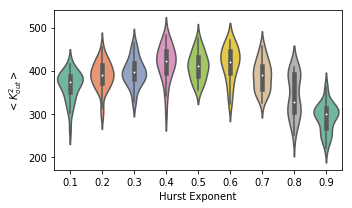

Text(0.5, 0, 'Hurst Exponent')

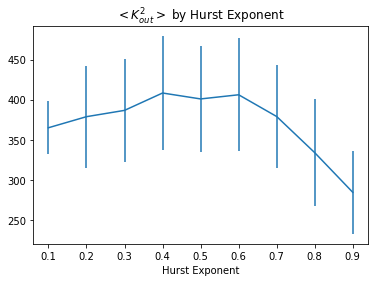

In [ ]:
MeanSquaredOutDeg_by_Hurst = pd.DataFrame()
MeanSquaredOutDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()
MeanSquaredOutDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_out_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanSquaredOutDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K^2_{out}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K^2_{out}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_of_squared_out_deg.pdf')
###############################################################################################
MeanSquaredOutDeg_STAT_by_Hurst = pd.DataFrame()
MeanSquaredOutDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
MeanSquaredOutDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_out_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanSquaredOutDeg_STAT_by_Hurst.columns,
             MeanSquaredOutDeg_STAT_by_Hurst.loc['mean'],
             yerr= MeanSquaredOutDeg_STAT_by_Hurst.loc['std'],
             xerr=None,
             fmt='', ecolor=None, elinewidth=None, capsize=None,
             barsabove=False, lolims=False, uplims=False,
             xlolims=False, xuplims=False, errorevery=1,
             capthick=None)
plt.title('$<K^2_{out}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_of_squared_in_deg

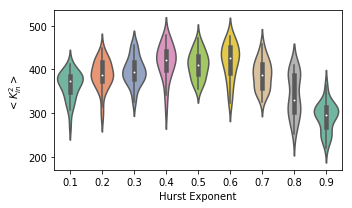

Text(0.5, 0, 'Hurst Exponent')

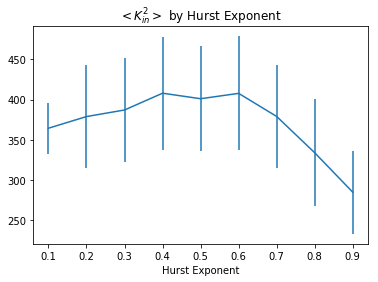

In [ ]:
MeanSquaredInDeg_by_Hurst = pd.DataFrame()
MeanSquaredInDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()
MeanSquaredInDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_in_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanSquaredInDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K^2_{in}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K^2_{in}>$ ')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_of_squared_in_deg.pdf')
###############################################################################################
MeanSquaredInDeg_STAT_by_Hurst = pd.DataFrame()
MeanSquaredInDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
MeanSquaredInDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_in_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanSquaredInDeg_STAT_by_Hurst.columns,
             MeanSquaredInDeg_STAT_by_Hurst.loc['mean'],
             yerr= MeanSquaredInDeg_STAT_by_Hurst.loc['std'],
             xerr=None,
             fmt='', ecolor=None, elinewidth=None, capsize=None,
             barsabove=False, lolims=False, uplims=False,
             xlolims=False, xuplims=False, errorevery=1,
             capthick=None)
plt.title('$<K^2_{in}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_of_squared_total_deg

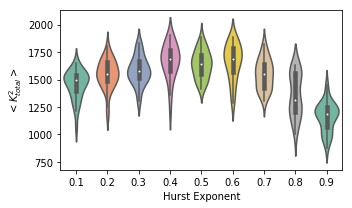

Text(0.5, 0, 'Hurst Exponent')

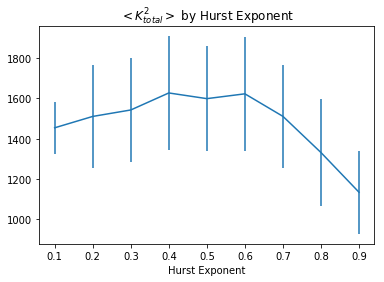

In [ ]:
MeanSquaredTotalDeg_by_Hurst = pd.DataFrame()
MeanSquaredTotalDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()
MeanSquaredTotalDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_total_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanSquaredTotalDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K^2_{total}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K^2_{total}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_of_squared_total_deg.pdf')
###############################################################################################
MeanSquaredTotalDeg_STAT_by_Hurst = pd.DataFrame()
MeanSquaredTotalDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
MeanSquaredTotalDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_of_squared_total_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanSquaredTotalDeg_STAT_by_Hurst.columns,
             MeanSquaredTotalDeg_STAT_by_Hurst.loc['mean'],
             yerr= MeanSquaredTotalDeg_STAT_by_Hurst.loc['std'],
             xerr=None,
             fmt='', ecolor=None, elinewidth=None, capsize=None,
             barsabove=False, lolims=False, uplims=False,
             xlolims=False, xuplims=False, errorevery=1,
             capthick=None)
plt.title('$<K^2_{total}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_out_deg

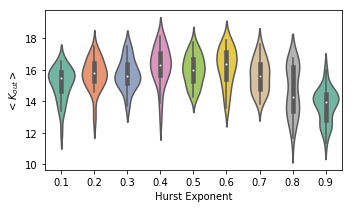

Text(0.5, 0, 'Hurst Exponent')

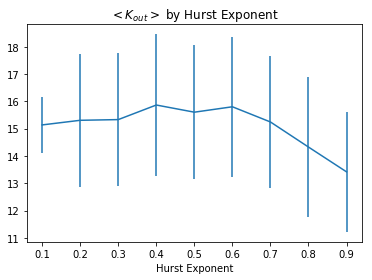

In [ ]:
MeanOutDeg_by_Hurst = pd.DataFrame()
MeanOutDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_out_deg'][0:32].copy()
MeanOutDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_out_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanOutDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K_{out}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K_{out}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_out_deg.pdf')
###############################################################################################
MeanOutDeg_STAT_by_Hurst = pd.DataFrame()
MeanOutDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
MeanOutDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_out_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanOutDeg_STAT_by_Hurst.columns,
             MeanOutDeg_STAT_by_Hurst.loc['mean'],
             yerr= MeanOutDeg_STAT_by_Hurst.loc['std'],
             xerr=None,
             fmt='', ecolor=None, elinewidth=None, capsize=None,
             barsabove=False, lolims=False, uplims=False,
             xlolims=False, xuplims=False, errorevery=1,
             capthick=None)
plt.title('$<K_{out}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_in_deg

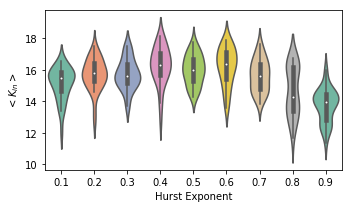

Text(0.5, 0, 'Hurst Exponent')

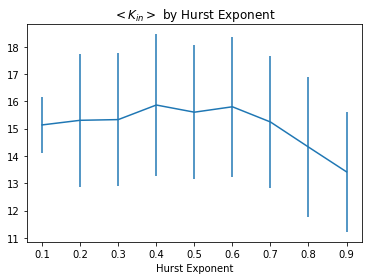

In [ ]:
MeanInDeg_by_Hurst = pd.DataFrame()
MeanInDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_in_deg'][0:32].copy()
MeanInDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_in_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanInDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K_{in}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K_{in}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_in_deg.pdf')
###############################################################################################
MeanInDeg_STAT_by_Hurst = pd.DataFrame()
MeanInDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
MeanInDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_in_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanInDeg_STAT_by_Hurst.columns,
                   MeanInDeg_STAT_by_Hurst.loc['mean'],
                   yerr= MeanInDeg_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<K_{in}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_total_deg

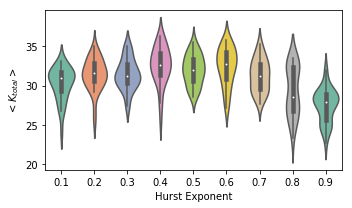

Text(0.5, 0, 'Hurst Exponent')

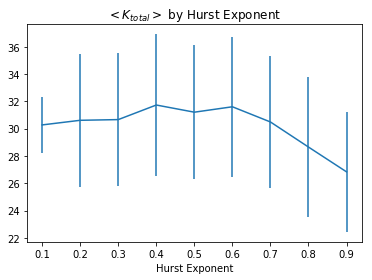

In [ ]:
MeanTotalDeg_by_Hurst = pd.DataFrame()
MeanTotalDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_total_deg'][0:32].copy()
MeanTotalDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_total_deg'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= MeanTotalDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<K_{total}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<K_{total}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_total_deg.pdf')
###############################################################################################
MeanTotalDeg_STAT_by_Hurst = pd.DataFrame()
MeanTotalDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
MeanTotalDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_total_deg'][['mean', 'std']].copy()
ax2 = plt.errorbar(MeanTotalDeg_STAT_by_Hurst.columns,
                   MeanTotalDeg_STAT_by_Hurst.loc['mean'],
                   yerr= MeanTotalDeg_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<K_{total}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# deg_total_std

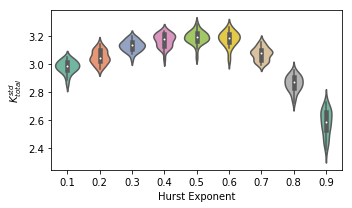

Text(0.5, 0, 'Hurst Exponent')

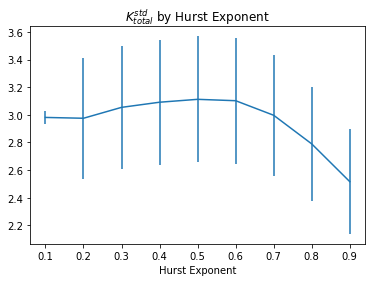

In [ ]:
DegTotalSTD_by_Hurst = pd.DataFrame()
DegTotalSTD_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['deg_total_std'][0:32].copy()
DegTotalSTD_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['deg_total_std'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= DegTotalSTD_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$K_{total}^{std}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$K_{total}^{std}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'deg_total_std.pdf')
###############################################################################################
DegTotalSTD_STAT_by_Hurst = pd.DataFrame()
DegTotalSTD_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
DegTotalSTD_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['deg_total_std'][['mean', 'std']].copy()
ax2 = plt.errorbar(DegTotalSTD_STAT_by_Hurst.columns,
                   DegTotalSTD_STAT_by_Hurst.loc['mean'],
                   yerr= DegTotalSTD_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$K_{total}^{std}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# global_clustCoef_std

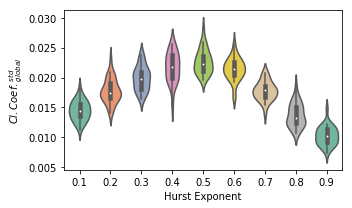

Text(0.5, 0, 'Hurst Exponent')

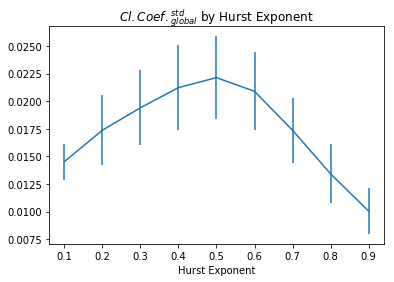

In [ ]:
globalClustCoef_STD_by_Hurst = pd.DataFrame()
globalClustCoef_STD_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['global_clustCoef_std'][0:32].copy()
globalClustCoef_STD_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['global_clustCoef_std'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= globalClustCoef_STD_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Cl.Coef.^{std}_{global}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Cl.Coef.^{std}_{global}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'global_clustCoef_std.pdf')
###############################################################################################
globalClustCoefSTD_STAT_by_Hurst = pd.DataFrame()
globalClustCoefSTD_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
globalClustCoefSTD_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['global_clustCoef_std'][['mean', 'std']].copy()
ax2 = plt.errorbar(globalClustCoefSTD_STAT_by_Hurst.columns,
                   globalClustCoefSTD_STAT_by_Hurst.loc['mean'],
                   yerr= globalClustCoefSTD_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Cl.Coef.^{std}_{global}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# local_clust_mean_undirected

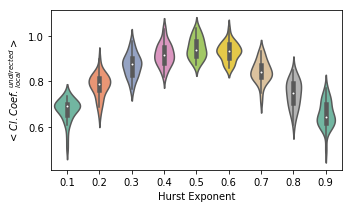

Text(0.5, 0, 'Hurst Exponent')

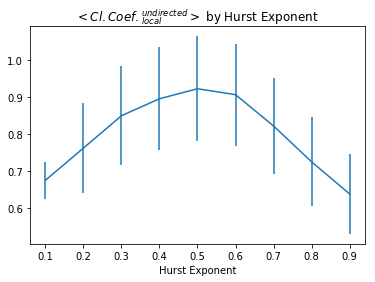

In [ ]:
localClustUndirected_MEAN_by_Hurst = pd.DataFrame()
localClustUndirected_MEAN_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()
localClustUndirected_MEAN_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['local_clust_mean_undirected'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= localClustUndirected_MEAN_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<Cl.Coef.^{undirected}_{local}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<Cl.Coef.^{undirected}_{local}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'local_clust_mean_undirected.pdf')
###############################################################################################
localClustUndirectedMEAN_STAT_by_Hurst = pd.DataFrame()
localClustUndirectedMEAN_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
localClustUndirectedMEAN_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['local_clust_mean_undirected'][['mean', 'std']].copy()
ax2 = plt.errorbar(localClustUndirectedMEAN_STAT_by_Hurst.columns,
                   localClustUndirectedMEAN_STAT_by_Hurst.loc['mean'],
                   yerr= localClustUndirectedMEAN_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<Cl.Coef.^{undirected}_{local}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# local_clust_mean_directed

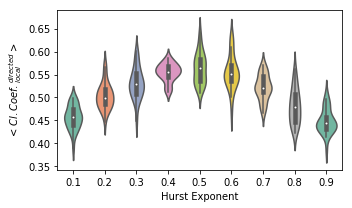

Text(0.5, 0, 'Hurst Exponent')

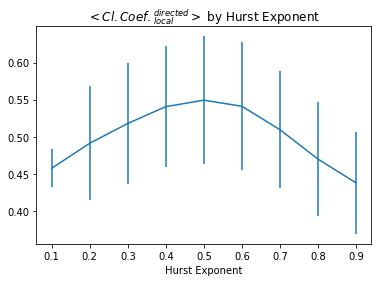

In [ ]:
localClustDirected_MEAN_by_Hurst = pd.DataFrame()
localClustDirected_MEAN_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()
localClustDirected_MEAN_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['local_clust_mean_directed'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= localClustDirected_MEAN_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<Cl.Coef.^{directed}_{local}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<Cl.Coef.^{directed}_{local}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'local_clust_mean_directed.pdf')
###############################################################################################
localClustDirectedMEAN_STAT_by_Hurst = pd.DataFrame()
localClustDirectedMEAN_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
localClustDirectedMEAN_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['local_clust_mean_directed'][['mean', 'std']].copy()
ax2 = plt.errorbar(localClustDirectedMEAN_STAT_by_Hurst.columns,
                   localClustDirectedMEAN_STAT_by_Hurst.loc['mean'],
                   yerr= localClustDirectedMEAN_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<Cl.Coef.^{directed}_{local}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# global_clustCoef

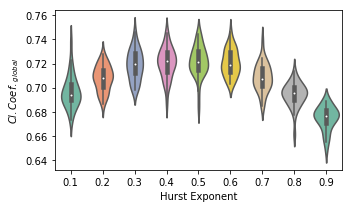

Text(0.5, 0, 'Hurst Exponent')

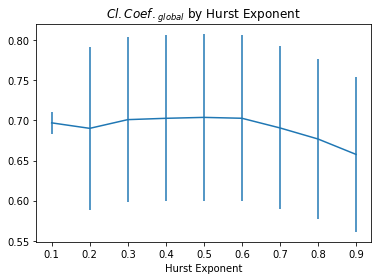

In [ ]:
globalClustCoef_by_Hurst = pd.DataFrame()
globalClustCoef_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['global_clustCoef'][0:32].copy()
globalClustCoef_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['global_clustCoef'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= globalClustCoef_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Cl.Coef._{global}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Cl.Coef._{global}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'global_clustCoef.pdf')
###############################################################################################
globalClustCoef_STAT_by_Hurst = pd.DataFrame()
globalClustCoef_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
globalClustCoef_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['global_clustCoef'][['mean', 'std']].copy()
ax2 = plt.errorbar(globalClustCoef_STAT_by_Hurst.columns,
                   globalClustCoef_STAT_by_Hurst.loc['mean'],
                   yerr= globalClustCoef_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Cl.Coef._{global}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# scalar_assortativity_coef_var

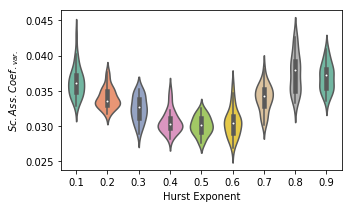

Text(0.5, 0, 'Hurst Exponent')

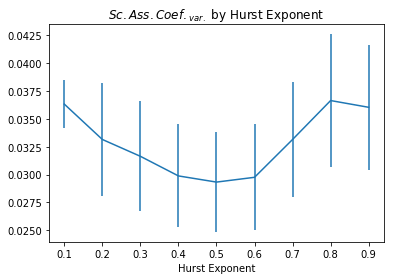

In [ ]:
scalarAssortativityVAR_by_Hurst = pd.DataFrame()
scalarAssortativityVAR_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()
scalarAssortativityVAR_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['scalar_assortativity_coef_var'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= scalarAssortativityVAR_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Sc.Ass.Coef._{var.}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Sc.Ass.Coef._{var.}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'scalar_assortativity_coef_var.pdf')
###############################################################################################
scalarAssortativityVAR_STAT_by_Hurst = pd.DataFrame()
scalarAssortativityVAR_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
scalarAssortativityVAR_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['scalar_assortativity_coef_var'][['mean', 'std']].copy()
ax2 = plt.errorbar(scalarAssortativityVAR_STAT_by_Hurst.columns,
                   scalarAssortativityVAR_STAT_by_Hurst.loc['mean'],
                   yerr= scalarAssortativityVAR_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Sc.Ass.Coef._{var.}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_directed_length

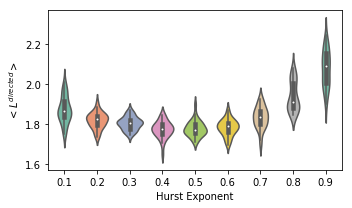

Text(0.5, 0, 'Hurst Exponent')

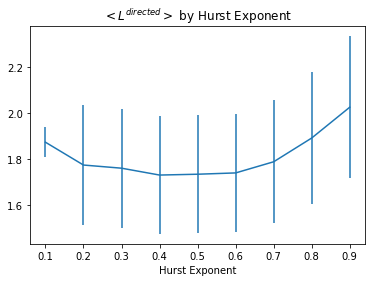

In [ ]:
directedLengthMEAN_by_Hurst = pd.DataFrame()
directedLengthMEAN_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_directed_length'][0:32].copy()
directedLengthMEAN_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_directed_length'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= directedLengthMEAN_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<L^{directed}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<L^{directed}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_directed_length.pdf')
###############################################################################################
directedLengthMEAN_STAT_by_Hurst = pd.DataFrame()
directedLengthMEAN_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
directedLengthMEAN_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_directed_length'][['mean', 'std']].copy()
ax2 = plt.errorbar(directedLengthMEAN_STAT_by_Hurst.columns,
                   directedLengthMEAN_STAT_by_Hurst.loc['mean'],
                   yerr= directedLengthMEAN_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<L^{directed}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# mean_undirected_length

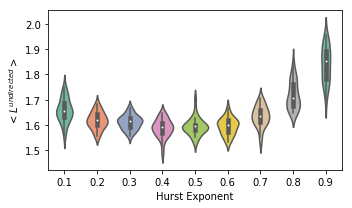

Text(0.5, 0, 'Hurst Exponent')

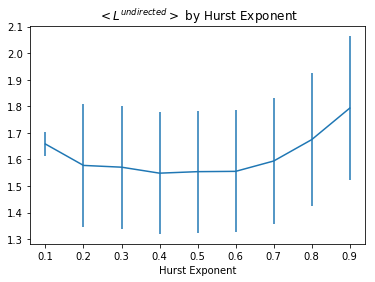

In [ ]:
undirectedLengthMEAN_by_Hurst = pd.DataFrame()
undirectedLengthMEAN_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_undirected_length'][0:32].copy()
undirectedLengthMEAN_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_undirected_length'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= undirectedLengthMEAN_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$<L^{undirected}>$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$<L^{undirected}>$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'mean_undirected_length.pdf')
###############################################################################################
undirectedLengthMEAN_STAT_by_Hurst = pd.DataFrame()
undirectedLengthMEAN_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
undirectedLengthMEAN_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['mean_undirected_length'][['mean', 'std']].copy()
ax2 = plt.errorbar(undirectedLengthMEAN_STAT_by_Hurst.columns,
                   undirectedLengthMEAN_STAT_by_Hurst.loc['mean'],
                   yerr= undirectedLengthMEAN_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$<L^{undirected}>$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# assortativity_coef_var

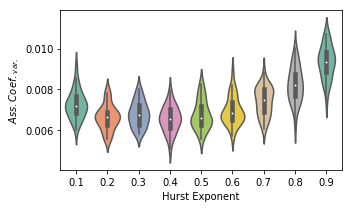

Text(0.5, 0, 'Hurst Exponent')

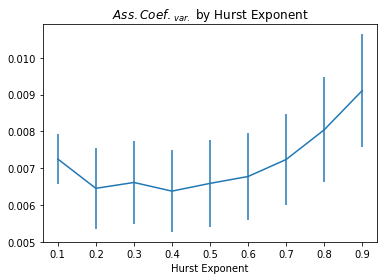

In [ ]:
AssortativityVAR_by_Hurst = pd.DataFrame()
AssortativityVAR_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['assortativity_coef_var'][0:32].copy()
AssortativityVAR_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['assortativity_coef_var'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize= (5,3))
ax1 = sns.violinplot(data= AssortativityVAR_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Ass.Coef._{var.}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Ass.Coef._{var.}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'assortativity_coef_var.pdf')
###############################################################################################
AssortativityVAR_STAT_by_Hurst = pd.DataFrame()
AssortativityVAR_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
AssortativityVAR_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['assortativity_coef_var'][['mean', 'std']].copy()
ax2 = plt.errorbar(AssortativityVAR_STAT_by_Hurst.columns,
                   AssortativityVAR_STAT_by_Hurst.loc['mean'],
                   yerr= AssortativityVAR_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Ass.Coef._{var.}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# assortativity_coef

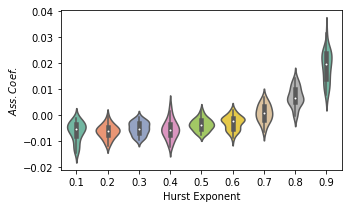

Text(0.5, 0, 'Hurst Exponent')

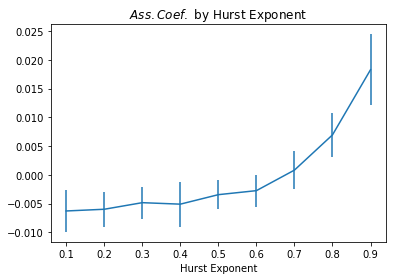

In [ ]:
Assortativity_by_Hurst = pd.DataFrame()
Assortativity_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['assortativity_coef'][0:32].copy()
Assortativity_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['assortativity_coef'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize = (5,3))
ax1 = sns.violinplot(data= Assortativity_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Ass.Coef.$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Ass.Coef.$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'assortativity_coef.pdf')
###############################################################################################
Assortativity_STAT_by_Hurst = pd.DataFrame()
Assortativity_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
Assortativity_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['assortativity_coef'][['mean', 'std']].copy()
ax2 = plt.errorbar(Assortativity_STAT_by_Hurst.columns,
                   Assortativity_STAT_by_Hurst.loc['mean'],
                   yerr= Assortativity_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Ass.Coef.$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# scalar_assortativity_coef

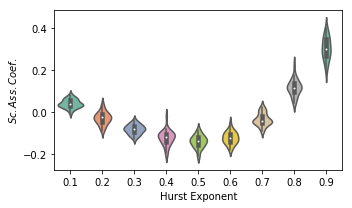

Text(0.5, 0, 'Hurst Exponent')

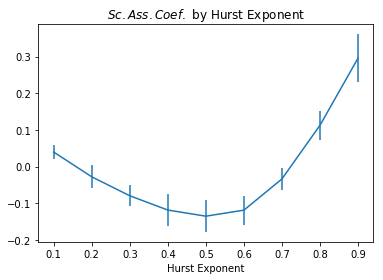

In [ ]:
scalarAssortativity_by_Hurst = pd.DataFrame()
scalarAssortativity_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()
scalarAssortativity_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['scalar_assortativity_coef'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= scalarAssortativity_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('$Sc.Ass.Coef.$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Sc.Ass.Coef.$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'scalar_assortativity_coef.pdf')
###############################################################################################
scalarAssortativity_STAT_by_Hurst = pd.DataFrame()
scalarAssortativity_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
scalarAssortativity_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['scalar_assortativity_coef'][['mean', 'std']].copy()
ax2 = plt.errorbar(scalarAssortativity_STAT_by_Hurst.columns,
                   scalarAssortativity_STAT_by_Hurst.loc['mean'],
                   yerr= scalarAssortativity_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Sc.Ass.Coef.$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# Deformation Ratio

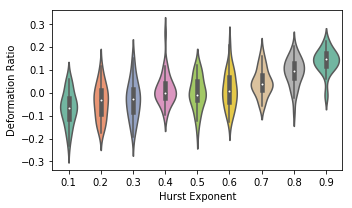

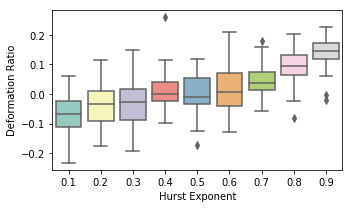

Text(0.5, 0, 'Hurst Exponent')

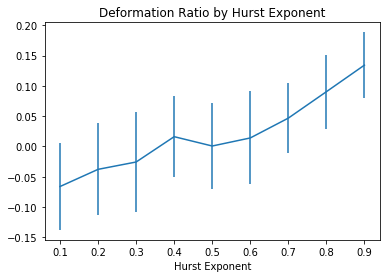

In [ ]:
deformation_by_Hurst = pd.DataFrame()
deformation_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['deformation_ratio'][0:32].copy()
deformation_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['deformation_ratio'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= deformation_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
# ax1.set_title('Deformation Ratio by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('Deformation Ratio')
plt.tight_layout()
plt.show()
fig1.savefig(path+'deformation_ratio.pdf')

import seaborn as sns
fig2 = plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data = deformation_by_Hurst, palette="Set3") #x="day", y="total_bill", 
# ax2 = sns.swarmplot(data = deformation_by_Hurst, color=".8") #x="day", y="total_bill",
ax2.set_xlabel('Hurst Exponent')
ax2.set_ylabel('Deformation Ratio')
plt.tight_layout()
plt.show()
fig2.savefig(path+'-boxplot_deformation_ratio.pdf')
###############################################################################################
deformation_STAT_by_Hurst = pd.DataFrame()
deformation_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
deformation_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['deformation_ratio'][['mean', 'std']].copy()
ax2 = plt.errorbar(deformation_STAT_by_Hurst.columns,
             deformation_STAT_by_Hurst.loc['mean'],
             yerr= deformation_STAT_by_Hurst.loc['std'],
             xerr=None,
             fmt='', ecolor=None, elinewidth=None, capsize=None,
             barsabove=False, lolims=False, uplims=False,
             xlolims=False, xuplims=False, errorevery=1,
             capthick=None)
plt.title('Deformation Ratio by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# modularity_deg_total

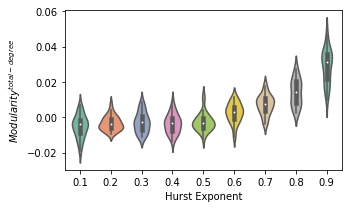

Text(0.5, 0, 'Hurst Exponent')

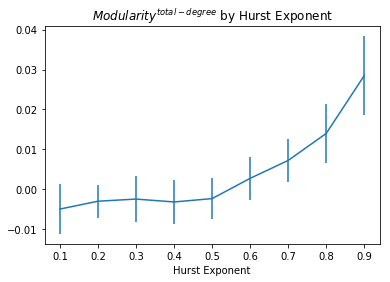

In [ ]:
modularityTotalDeg_by_Hurst = pd.DataFrame()
modularityTotalDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['modularity_deg_total'][0:32].copy()
modularityTotalDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['modularity_deg_total'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= modularityTotalDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
#ax1.set_title('$Modularity^{total-degree}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Modularity^{total-degree}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'modularity_deg_total.pdf')
###############################################################################################
modularityTotalDeg_STAT_by_Hurst = pd.DataFrame()
modularityTotalDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
modularityTotalDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['modularity_deg_total'][['mean', 'std']].copy()
ax2 = plt.errorbar(modularityTotalDeg_STAT_by_Hurst.columns,
                   modularityTotalDeg_STAT_by_Hurst.loc['mean'],
                   yerr= modularityTotalDeg_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Modularity^{total-degree}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


# modularity_deg_out

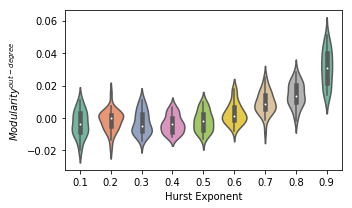

0.1         0.2         0.3         0.4         0.5         0.6  \
mean -0.00338364 -0.00149057 -0.00264365 -0.00362929 -0.00181081  0.00291538   
std   0.00782524  0.00638481   0.0069799  0.00550642    0.006258  0.00634994   

             0.7         0.8        0.9  
mean  0.00953782   0.0144808  0.0310202  
std   0.00696212  0.00730165  0.0109155

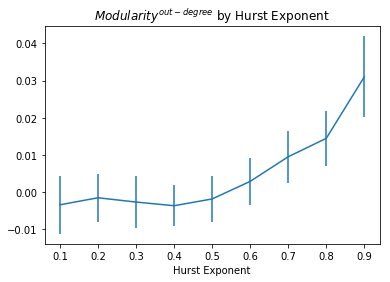

In [ ]:
modularityOutDeg_by_Hurst = pd.DataFrame()
modularityOutDeg_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['modularity_deg_out'][0:32].copy()
modularityOutDeg_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['modularity_deg_out'][0:32].copy()

import seaborn as sns
fig1 = plt.figure(figsize=(5,3))
ax1 = sns.violinplot(data= modularityOutDeg_by_Hurst,
                    scale = 'area', # count,width, area
                    inner= "box", #box, quartile, point, stick
                    palette="Set2",
                   )
#ax1.set_title('$Modularity^{out-degree}$ by Hurst Exponent')
ax1.set_xlabel('Hurst Exponent')
ax1.set_ylabel('$Modularity^{out-degree}$')
plt.tight_layout()
plt.show()
fig1.savefig(path+'modularity_deg_out.pdf')
###############################################################################################
modularityOutDeg_STAT_by_Hurst = pd.DataFrame()
modularityOutDeg_STAT_by_Hurst['0.1'] = df_H_1_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.2'] = df_H_2_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.3'] = df_H_3_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.4'] = df_H_4_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.5'] = df_H_5_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.6'] = df_H_6_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.7'] = df_H_7_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.8'] = df_H_8_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
modularityOutDeg_STAT_by_Hurst['0.9'] = df_H_9_ensemble_Network.T['modularity_deg_out'][['mean', 'std']].copy()
ax2 = plt.errorbar(modularityOutDeg_STAT_by_Hurst.columns,
                   modularityOutDeg_STAT_by_Hurst.loc['mean'],
                   yerr= modularityOutDeg_STAT_by_Hurst.loc['std'],
                   xerr=None,
                   fmt='', ecolor=None, elinewidth=None, capsize=None,
                   barsabove=False, lolims=False, uplims=False,
                   xlolims=False, xuplims=False, errorevery=1,
                   capthick=None)
plt.title('$Modularity^{out-degree}$ by Hurst Exponent')
plt.xlabel('Hurst Exponent')


In [ ]:
df_fgn_NetworkMeasures = pd.DataFrame()

df_fgn_NetworkMeasures['mean_of_squared_out_deg'] = MeanSquaredOutDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_of_squared_in_deg'] = MeanSquaredInDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_of_squared_total_deg'] = MeanSquaredTotalDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_out_deg'] = MeanOutDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_in_deg'] = MeanInDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_total_deg'] = MeanTotalDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['deg_total_std'] = DegTotalSTD_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['global_clustCoef_std'] = globalClustCoefSTD_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['local_clust_mean_undirected'] = localClustUndirectedMEAN_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['local_clust_mean_directed'] = localClustDirectedMEAN_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['global_clustCoef'] = globalClustCoef_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['scalar_assortativity_coef_var'] = scalarAssortativityVAR_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_directed_length'] = directedLengthMEAN_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['mean_undirected_length'] = undirectedLengthMEAN_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['assortativity_coef_var'] = AssortativityVAR_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['assortativity_coef'] = Assortativity_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['scalar_assortativity_coef'] = scalarAssortativity_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['deformation_ratio'] = deformation_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['modularity_deg_total'] = modularityTotalDeg_STAT_by_Hurst.loc['mean']
df_fgn_NetworkMeasures['modularity_deg_out'] = modularityOutDeg_STAT_by_Hurst.loc['mean']

df_fgn_NetworkMeasures.to_pickle(path+'df_fgn_NetworkMeasures.pickle')


In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

df_fgn_NetworkMeasures = pd.read_pickle(path+'df_fgn_NetworkMeasures.pickle')
df_fgn_NetworkMeasures

mean_of_squared_out_deg mean_of_squared_in_deg mean_of_squared_total_deg  \
0.1                 365.075                364.259                    1454.1   
0.2                 388.598                388.469                    1549.3   
0.3                 396.675                396.886                   1582.28   
0.4                 418.828                418.276                   1668.76   
0.5                 411.333                411.318                   1640.13   
0.6                 416.575                418.055                   1664.28   
0.7                 388.767                388.586                   1549.57   
0.8                 342.254                341.945                   1364.15   
0.9                 291.674                291.738                   1162.44   

    mean_out_deg mean_in_deg mean_total_deg deg_total_std  \
0.1      15.1365     15.1365        30.2729       2.98137   
0.2      15.7005     15.7005         31.401       3.05255   
0.3      15.7271     15.7271        31.4542       3.13343   
0.4      16.2729     16.2729        32.5458       3.17169   
0.5      16.0057     16.0057        32.0115       3.19314   
0.6      16.2073     16.2073        32.4146       3.18293   
0.7      15.6375     15.6375         31.275       3.07468   
0.8      14.6896     14.6896        29.3792       2.86202   
0.9      13.7635     13.7635        27.5271       2.58164   

    global_clustCoef_std local_clust_mean_undirected  \
0.1            0.0145233                     0.67539   
0.2            0.0178045                    0.782274   
0.3            0.0198924                    0.872249   
0.4            0.0217592                    0.919447   
0.5            0.0226948                    0.947298   
0.6            0.0214205                    0.930908   
0.7            0.0178093                    0.843843   
0.8            0.0137574                    0.744251   
0.9            0.0102941                    0.655021   

    local_clust_mean_directed global_clustCoef scalar_assortativity_coef_var  \
0.1                   0.45729         0.696907                     0.0363279   
0.2                  0.503807         0.707959                     0.0340131   
0.3                  0.531165         0.719097                     0.0324607   
0.4                  0.554504         0.720795                     0.0306548   
0.5                  0.563408         0.721976                     0.0300877   
0.6                  0.554975         0.720851                     0.0305248   
0.7                  0.522575         0.708511                       0.03401   
0.8                  0.481778         0.694353                     0.0375904   
0.9                  0.448984          0.67467                      0.036974   

    mean_directed_length mean_undirected_length assortativity_coef_var  \
0.1              1.87237                1.65811             0.00724808   
0.2              1.81903                1.61846              0.0066159   
0.3              1.80497                 1.6116              0.0067796   
0.4              1.77434                1.58849             0.00653789   
0.5              1.77806                 1.5943             0.00675258   
0.6              1.78387                1.59548             0.00694498   
0.7              1.83364                1.63548             0.00741814   
0.8              1.93965                1.71821             0.00824304   
0.9              2.07709                1.83998             0.00933847   

    assortativity_coef scalar_assortativity_coef deformation_ratio  \
0.1        -0.00630084                 0.0396833        -0.0661988   
0.2        -0.00628242                 -0.029688        -0.0413814   
0.3        -0.00509216                -0.0829658        -0.0290938   
0.4        -0.00539412                 -0.123679         0.0145276   
0.5        -0.00364683                 -0.140806       -0.00148426   
0.6        -0.00293398                 -0.123781         0.0120537   

# END OF fGn ANALYSIS

In [ ]:
df_H_1_ensemble_Network = pd.read_pickle(path+'df_H_1_ensemble_Network.pickle')
df_H_2_ensemble_Network = pd.read_pickle(path+'df_H_2_ensemble_Network.pickle')
df_H_3_ensemble_Network = pd.read_pickle(path+'df_H_3_ensemble_Network.pickle')
df_H_4_ensemble_Network = pd.read_pickle(path+'df_H_4_ensemble_Network.pickle')
df_H_5_ensemble_Network = pd.read_pickle(path+'df_H_5_ensemble_Network.pickle')
df_H_6_ensemble_Network = pd.read_pickle(path+'df_H_6_ensemble_Network.pickle')
df_H_7_ensemble_Network = pd.read_pickle(path+'df_H_7_ensemble_Network.pickle')
df_H_8_ensemble_Network = pd.read_pickle(path+'df_H_8_ensemble_Network.pickle')
df_H_9_ensemble_Network = pd.read_pickle(path+'df_H_9_ensemble_Network.pickle')
df_H_1_ensemble_Network[['mean', 'std']]

mean         std
mean_of_squared_out_deg         365.075000   33.342896
mean_of_squared_in_deg          364.259375   31.500690
mean_of_squared_total_deg      1454.096875  128.900599
mean_out_deg                     15.136458    1.025825
mean_in_deg                      15.136458    1.025825
mean_total_deg                   30.272917    2.051650
deg_total_std                     2.981368    0.045604
global_clustCoef_std              0.014523    0.001617
local_clust_mean_undirected       0.675390    0.049321
local_clust_mean_directed         0.457290    0.025418
global_clustCoef                  0.696907    0.013261
scalar_assortativity_coef_var     0.036328    0.002145
mean_directed_length              1.872368    0.064851
mean_undirected_length            1.658110    0.045537
assortativity_coef_var            0.007248    0.000675
assortativity_coef               -0.006301    0.003647
scalar_assortativity_coef         0.039683    0.020071
deformation_ratio                -0.066199    0.071701
modularity_deg_total             -0.005043    0.006238
modularity_deg_out               -0.003384    0.007825

In [ ]:

meanH01 = MeanSquaredOutDeg_STAT_by_Hurst.loc['mean', '0.1']
stdH01 = MeanSquaredOutDeg_STAT_by_Hurst.loc['std', '0.1']
DJIA_SSEC = 212.066667
z_DJIA_SSEC_vs_H01 = (DJIA_SSEC - meanH01)/stdH01
print(z_DJIA_SSEC_vs_H01)

from scipy import stats
alpha = 1 - stats.norm.cdf( z_DJIA_SSEC_vs_H01 ) 
print(alpha)

from scipy import stats
v = stats.norm.rvs(loc= meanH01 ,scale= stdH01, size= 500, random_state= None)
import matplotlib.pyplot as plt
plt.plot(range(0, len(v)),v, marker ='o')


NameError: name 'MeanSquaredOutDeg_STAT_by_Hurst' is not defined

# Old fGn Codes

In [ ]:
class CLASS_timeSeries():
    def __init__(self, series_name, path):
        self.series_name = series_name
        self.path = path
    def fGn(self, Hurst, length, column_name = 'logChange', t=1):
        self.Hurst = Hurst
#         self.series_name = 'H='+str(float(self.Hurst))
        from stochastic.noise import FractionalGaussianNoise
        fgn = FractionalGaussianNoise(Hurst, t)
        self.array_series = fgn.sample(n=length+1 , algorithm='hosking')
        self.df = pd.DataFrame({column_name:self.array_series})
        #---- lagged
        self.df_lag = pd.DataFrame()
        self.df_lag[column_name] = self.df[column_name].shift(1).copy()
        self.df_lag.dropna(axis=0,inplace=True)
        self.df_lag.reset_index(inplace=True)
        
        self.df = self.df.reindex(self.df.index.drop(0)).reset_index(drop=True)
        self.df.to_pickle(self.path+'df_'+self.series_name+'.pickle')
        self.df_lag.to_pickle(self.path+'df_'+self.series_name+'_lag.pickle')
#         print(len(self.df), len(self.df_lag))
#         self.df[column_name].head().plot()
#         plt.show()
#         self.df_lag[column_name].head().plot()
#         plt.show()
#         print(self.df[column_name].head())
#         print(self.df_lag[column_name].head())
    def Sample(self,length=9):

        edge_list=[]
        fig= plt.figure(figsize=(6,4))

        series1 = np.random.randint(48, 54, length)
        series2 = np.random.randint(48, 54, length)

        ax= plt.scatter(x=np.arange(1,length+1), y=series1, marker='o', color='r', alpha=0.5, label='Timeseries 1')
        ax= plt.scatter(x=np.arange(1,length+1), y=series2, marker='+', color='b', alpha=1, label='Timeseries 2')

        for i in np.arange(1,length+1):
            if series1[i-1] == series2[i-1]:
                edge_list+=['Loop']

            else: edge_list+=['Edge']

        for i in np.arange(1,length+1):
            if edge_list[i-1]=='Loop':
                ax= plt.text(i, 54, edge_list[i-1], color='green' ,bbox=dict(facecolor='w', alpha=1))
            else:
                ax= plt.text(i, 54, edge_list[i-1], color='violet' ,bbox=dict(facecolor='w', alpha=1))

        plt.xlim([0.5, 10])
        plt.ylim([47.5, 55])

        plt.yticks([])
        plt.grid()
        plt.xticks(np.arange(1, length+1), rotation=0)
        plt.title("Connection Type in Mapping from Timeseries onto Network")
        plt.ylabel('Timeseries Amplitude')
        plt.xlabel("Sample Datapoints")
        plt.legend(loc='lower right')
        plt.tight_layout()

        return ax

    def input_df(self, df):
        self.df = df
        return self.df
    
    def df_to_xlsx(self):
        # Create a Pandas Excel writer using XlsxWriter aui7js the engine.
        writer = pd.ExcelWriter(self.path+self.series_name+".xlsx", engine='xlsxwriter')  # io.excel.xlsx.writer
        # Convert the dataframe to an XlsxWriter Excel object.
        self.df.to_excel(writer)
        # Close the Pandas Excel writer and output the Excel file.
        writer.save()
        # print is successfully done!!!'
    
    def readExcel_series(self,fileName,column_name, length = 2000):
        df_0 = pd.read_excel(
            '/home/jamshid/Dropbox/spectral analysis of mapping time series onto complex networks/database/2009-2019/'+
            self.series_name+'.xlsx')
        #msno.matrix(df_0)

        df_0.interpolate(method ='linear', inplace=True)
        df_0[column_name].replace('null', np.nan, inplace=True)
        df_0[column_name].replace(0, np.nan, inplace=True)        
        #msno.matrix(df_0)
        df_0.fillna({column_name:np.nan}, inplace=True)
        msno.matrix(df_0)
        df_0[column_name].astype('float', inplace=True)
        df_0["logChange"] = np.log(df_0[column_name]/df_0[column_name].shift(1))
        df_0.dropna(inplace =True, how ="any") #inplace=True,
        df_0.reset_index(inplace=True)
        
#         df_0["logChange"] = (df_0["logChange"]-df_0["logChange"].mean())/df_0["logChange"].std()

        df_0['datetime']=pd.to_datetime(df_0['Date'])
        #df_0.set_index('datetime',inplace=True)
        df_0.drop(['Date'],axis=1,inplace=True)
        self.df = df_0.iloc[-length::].reset_index().copy()
        print(self.series_name+"\'s length:    ",len(self.df))
        self.df.to_pickle(self.path+'df_'+self.series_name+'.pickle')
        return self.df

    def PLOT_series(self, title ,column_name="logChange"):
        fig_series = plt.figure(figsize=(5,3))
        ax = plt.plot(self.df[column_name], linewidth = 0.2)
        plt.grid()
        plt.title(title)
        plt.tight_layout()
        fig_series.savefig(self.path+self.series_name+'_series.png', dpi=100)
        return ax
        
    def Autocorrelation(self, max_lag, column_name):
        self.max_lag= max_lag
        self.array_series = np.asarray(self.df[column_name])
        list_ret = np.zeros( (max_lag-1, len(self.array_series)-max_lag) )
        #print(list_ret,"\n","row=",max_lag-1,"col=",len(self.array_series)-max_lag)
        for i in range(1,max_lag):
#             print("##################\n",i)
#             print("\n\t timeseries:\n",
#                   self.time_series)
#             print("\n\t timeseries[i:]:\n",
#                   self.time_series[i:])
            ti = (self.array_series[i:] - self.array_series[:len(self.array_series)-i])
            ti = ti[:len(ti)-max_lag+i]
#             print("\n\t time_series[:len(time_series)-i]: \n",
#                   self.time_series[:len(self.time_series)-i])
#             print("\n\t time_series[i:] - time_series[:len(time_series)-i]: \n",
#                   self.time_series[i:] - self.time_series[:len(self.time_series)-i])
#             print("\n\t [:-max_lag+i]:",-self.max_lag+i)
#             print("\n\t ti=\n",(self.time_series[i:] - self.time_series[:len(self.time_series)-i])[:-self.max_lag+i])

#             print("\n\t np.mean(ti):\n",np.mean(ti))
            ti -= np.mean(ti)
#             print("\n\t ti= \n",ti)

#             print("\n\t np.std(ti):\n",np.mean(ti))
            ti /= np.std(ti)
#             print("\n\t ti=\n",ti)

            list_ret[i-1] = ti
#             print("\n\n list_ret[i-1] = ti \n",list_ret[i-1])
            
        n = list_ret.shape[1]
#         print("n=",n)

#         plt.plot(list_ret.T)
#         plt.title(self.series_name+" with lags untill "+str(max_lag))
#         plt.show()
            
        self.autocorr = (list_ret @ list_ret.T)/n
        #print("corr:\n",np.float16(self.corr))

        return self.autocorr
    
    def PLOT_Autocorrelation(self, title):
        fig_autocorrelation = plt.figure(figsize=(5,5))
        imshow =plt.imshow(self.autocorr, vmin=0, vmax=1)
        plt.colorbar(shrink=0.85)
        plt.xticks(np.arange(0,self.max_lag-1,10))
        plt.yticks(np.arange(0,self.max_lag-1,10))
        plt.title(title)
        fig_autocorrelation.savefig(self.path+self.series_name+'_AC_matrix.png', dpi=100)
        
        
        
##################################################################################################
##################################################################################################
##################################################################################################

#### fGn Auto-correlation Matrix

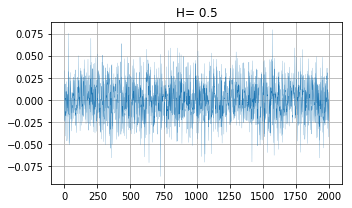

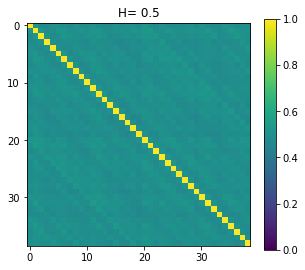

In [ ]:

###  fGn noise  ###############################################################
#==================
import os
folder_name = 'output-1-fGn-generate'
current_dir = os.getcwd()
path_to_load = current_dir+'/'+folder_name+'/'
os.makedirs(path_to_load, exist_ok=True)
#==================

noise_ObjectDicts={}
for Hurst in tqdm_notebook(Hurst_list):
    ensemble_no = 1
    while ensemble_no =<32:
    # making fGn object >>> 0: key: Hurst, value: object
    noise_ObjectDicts[Hurst+'_ensemble_no_'+ensemble_no] = [CLASS_timeSeries('H='+str(Hurst),path_to_load)]
    
    #2: key: Hurst, value: PLOT series
    noise_ObjectDicts[Hurst].append(
        noise_ObjectDicts[Hurst][0].fGn(Hurst,
                                        length= 2000,
                                        column_name="logChange",
                                        t=1))
    
    #3: key: Hurst, value: autocorrelation
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].PLOT_series(title = 'H= '+str(Hurst), column_name="logChange"))
    
    #4: key: Hurst, value: PLOT autocorrelation
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].Autocorrelation(max_lag =40,
#                                                     column_name='logChange'))
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].PLOT_Autocorrelation(title = 'H= '+str(Hurst)))  
    
    noise_ObjectDicts[Hurst][0].df_to_xlsx()
    
    